### Forecasting BTC-USD Realized Volatility 

Volatility can either be historical or implied; both are usually expressed on an annualized basis in percentage terms. 

- **Historical Volatility** (HV) or **Realized Volatility** is the actual volatility demonstrated by the underlying over a period of time, such as the past month or year. 
- **Implied volatility** (IV), on the other hand, is the level of volatility of the underlying that is implied by the current option price. 

(source: https://www.investopedia.com/articles/investing/021716/strategies-trading-volatility-options-nflx.asp)

The fundamental equation in option trading is:

$P/L = Vega|\sigma_{implied} - \sigma_{realized}|$

in which Vega measures an option’s price sensitivity, or the price change of an option for every 1% change in volatility of the underlying.

If we can identify situations where the above volatility mismatch occurs, there's potential Profit or Loss that can be captured.

(source: **Positional Option Trading: An Advanced Guide** by Euan Sinclair)

The purpose of this project is to forecast one variable of the above equation: the **realized volatility** based on historical/past data using time series analysis. The basic idea we want to describe here is the average forward-looking realized volatility of BTC-USD (returns or log returns of close price of BTC-USD of the next few days as estimated at the end of time step `t`).

“Volatility does **not** measure the direction of price changes, merely their dispersion. This is because when calculating standard deviation (or variance), all differences are squared, so that negative and positive differences are combined into one quantity. Two instruments with different volatilities may have the same expected return, but the instrument with higher volatility will have larger swings in values over a given period of time.”
(source: Wikipedia)

### Challenges

Although the forecasting and modeling of volatility has been the focus of many empirical studies and theoretical investigations in academia, forecasting volatility accurately remains a crucial challenge for scholars. In addition, Crypto options trading is relatively new, there has not been too much research on the topic. There would be certain nuances to crypto that need to be accounted for in this project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install arch

In [4]:
!pip3 install yfinance

In [5]:
import yfinance as yf

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [7]:
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse, r2_score 
from sklearn.preprocessing import MinMaxScaler

In [8]:
# Ref: https://towardsdatascience.com/8-commonly-used-pandas-display-options-you-should-know-a832365efa95
# ADJUST COLUMN WIDTH IN PANDAS TO SHOW ALL TEXT
# (FOR RESULT DISPLAY LATER)

pd.set_option('display.max_colwidth', None)

In [9]:
start = datetime(2014, 1, 1)
end = datetime.today()

tckr = 'BTC-USD'

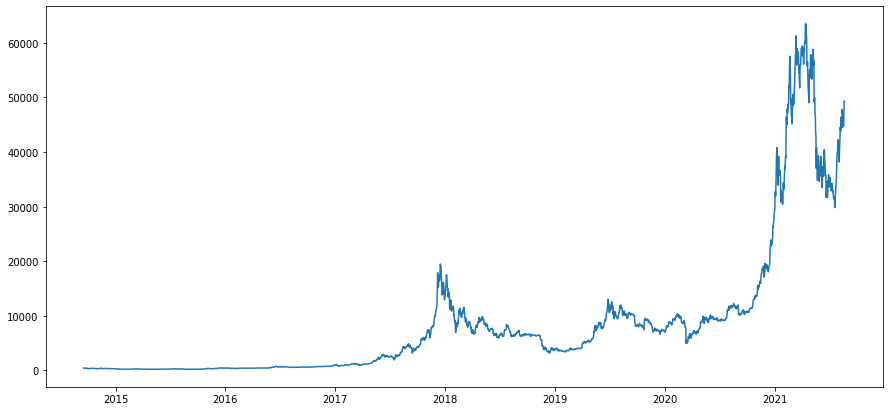

In [478]:
ticker = yf.Ticker(tckr)
df = ticker.history(start=start, 
                    end=end, 
                    interval="1d")

plt.figure(figsize=(15,7))
plt.plot(df.Close);

Volatility is calculated as the standard deviation of price returns, which is the dollar change in price as a percentage of previous day's price.

In [479]:
# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
df['returns'] = 100 * df.Close.pct_change().dropna()

Further research indicates that for practicality purposes it's preferable to use the log returns especially in modeling, because it helps eliminate non-stationary properties of time series data, and makes it more stable.


LOG RETURNS FORMULA:

$r_{t, t+i} = log(P_{t+i} / P_{t})$

There's another advantage to log returns, which is that they're additive across time: $r_{t1, t2} + r_{t2, t3} = r_{t1, t3}$


In [480]:
# CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
df['log_returns'] = np.log(df.Close/df.Close.shift(1))

In [481]:
df.tail()

Open          High  ...   returns  log_returns
Date                                    ...                       
2021-08-17  45936.457031  47139.570312  ... -2.845647    -0.028869
2021-08-18  44686.750000  45952.062500  ...  0.236777     0.002365
2021-08-19  44741.882812  46970.761719  ...  4.277544     0.041886
2021-08-20  46723.121094  49342.152344  ...  5.611587     0.054598
2021-08-21  49330.175781  49669.066406  ... -0.218877    -0.002191

[5 rows x 9 columns]

In [482]:
df.head()

Open        High  ...   returns  log_returns
Date                                ...                       
2014-09-17  465.864014  468.174011  ...       NaN          NaN
2014-09-18  456.859985  456.859985  ... -7.192558    -0.074643
2014-09-19  424.102997  427.834991  ... -6.984265    -0.072402
2014-09-20  394.673004  423.295990  ...  3.573492     0.035111
2014-09-21  408.084991  412.425995  ... -2.465854    -0.024968

[5 rows x 9 columns]

In [483]:
# DROPPING THE 1ST ROW OF DATA 
# BECAUSE I SHIFTED IT FORWARD TO CALCULATE RETURNS/LOG RETURNS
df.dropna(inplace=True)

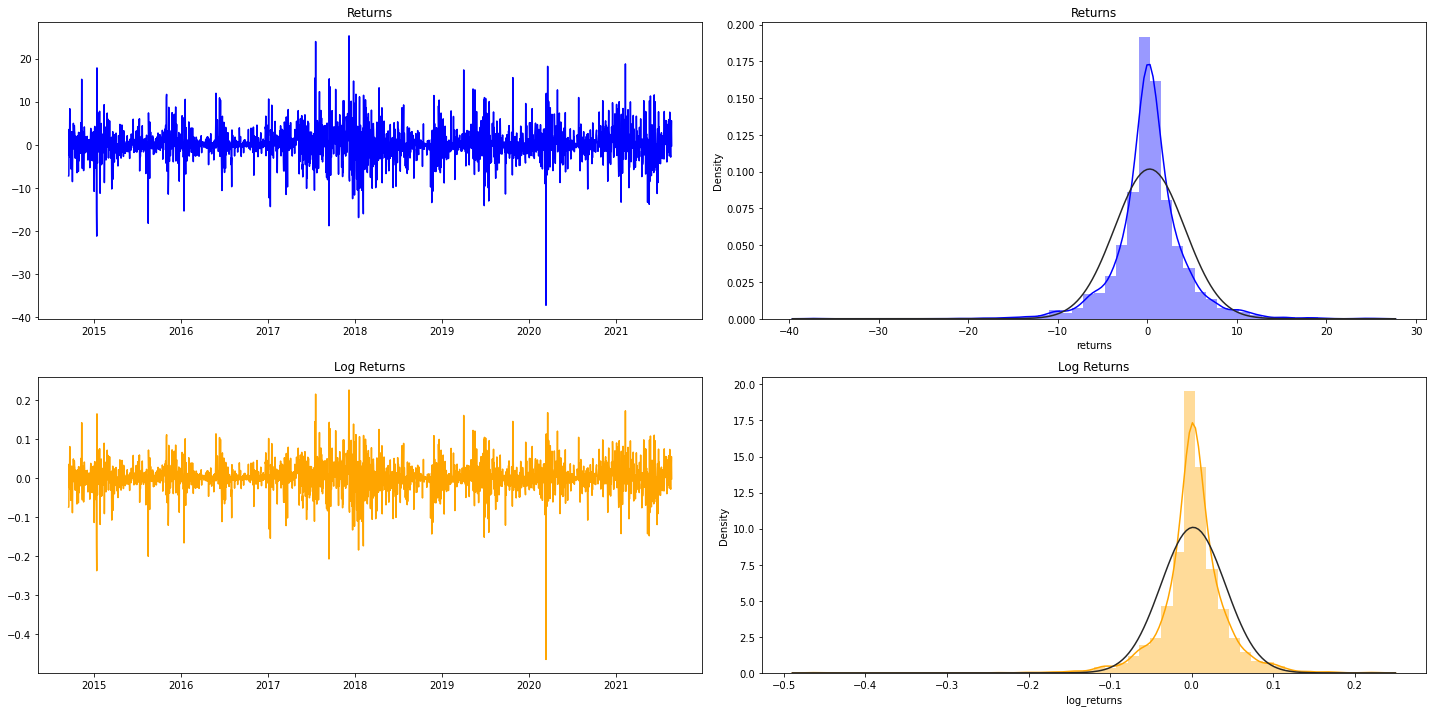

In [484]:
# PLOT DISTRIBUTION PLOTS OF RETURNS & LOG RETURNS
# AND VISUALLY COMPARE THEM WITH THE STANDARD NORMAL DISTRIBUTION
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

axes[0][0].plot(df.returns, color='blue')
axes[0][0].set_title('Returns')

sns.distplot(df.returns, norm_hist=True, fit=stats.norm, color='blue',
             bins=50, ax=axes[0][1])
axes[0][1].set_title('Returns')

axes[1][0].plot(df.log_returns, color='orange')
axes[1][0].set_title('Log Returns')

sns.distplot(df.log_returns, norm_hist=True, fit=stats.norm, color='orange',
             bins=50, ax=axes[1][1])
axes[1][1].set_title('Log Returns')
plt.tight_layout()
fig.show();

In [485]:
df.returns.describe()

count    2526.000000
mean        0.262979
std         3.919981
min       -37.169539
25%        -1.281712
50%         0.199977
75%         1.826251
max        25.247169
Name: returns, dtype: float64

In [486]:
df.log_returns.describe()

count    2526.000000
mean        0.001852
std         0.039539
min        -0.464730
25%        -0.012900
50%         0.001998
75%         0.018098
max         0.225119
Name: log_returns, dtype: float64

Both Returns & Log Returns show some:
- slight negative skewness
- positive kurtosis (leptokurtic) - higher peak with thick tails than the standard normal distribution.


(Source: https://www.investopedia.com/articles/investing/102715/computing-historical-volatility-excel.asp)

The standard deviation will be different for log returns computed over longer or shorter intervals. For this specific project, the volatility would be for a certain fixed window interval (`WINDOW_SIZE`) is the standard deviation of log returns, or the square root of the sum of squares of log returns:

$\sigma_{interval} = \sqrt{\sum_{t} r_{t-1, t}^2}$

And then to scale the daily volatility by a certain frequency (weekly, monthly, yearly), we can multiply the daily volatility by the square root of that frequency in terms of day divided by the interval minus 1 (`WINDOW_SIZE-1`). For example:

$\sigma_{daily} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{1}{interval-1}}$

$\sigma_{annualized} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{365}{interval-1}}$

$\sigma_{monthly} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{30}{interval-1}}$

$\sigma_{weekly} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{7}{interval-1}}$


In [487]:
# CREATE A FUNCTION THAT CALCULATE REALIZED VOLATILITY
# FROM SAILY LOG RETURNS
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    return np.sqrt(np.sum(series_log_return**2)/(WINDOW_SIZE-1))

For this specific project I'll experiment with an interval window of 30 days (equivalent to roughly 1 month of trading for cryptocurrencies). The goal here is to forecast the average realized volatility of the next `n_future` 7 days using a number of immediate past/historical datapoints (`n_past`). 

The reason I selected 30 days is because 7 days seems too short to observe meaningful patterns, and longer intervals seem to smooth the volatility down significantly. 

In [488]:
WINDOW_SIZE = 30
n_future = 7

In [489]:
# GET BACKWARD LOOKING REALIZED VOLATILITY
df['vol_current'] = df.log_returns.rolling(window=WINDOW_SIZE)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY 
df['vol_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=WINDOW_SIZE)\
                                 .apply(realized_volatility_daily)

In [490]:
df.describe()

Open          High  ...  vol_current   vol_future
count   2526.000000   2526.000000  ...  2497.000000  2490.000000
mean    8536.173186   8782.008219  ...     0.036373     0.036375
std    12604.231638  12999.115167  ...     0.017243     0.017267
min      176.897003    211.731003  ...     0.007228     0.007228
25%      572.634476    577.809250  ...     0.024470     0.024461
50%     5064.685791   5256.610352  ...     0.034074     0.033962
75%     9450.428467   9638.246826  ...     0.046047     0.046106
max    63523.753906  64863.097656  ...     0.103878     0.103878

[8 rows x 11 columns]

### Stationarity Checking

In [23]:
from statsmodels.tsa.stattools import adfuller

In [24]:
# LOG RETURNS
adfuller_results = adfuller(df.log_returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -15.102431555633517
p-value: 7.905439999516841e-28
Critical Values:
1%: -3.4330
5%: -2.8627
10%: -2.5674


In [25]:
# RETURNS
adfuller_results = adfuller(df.returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -15.047300015260122
p-value: 9.403786398386331e-28
Critical Values:
1%: -3.4330
5%: -2.8627
10%: -2.5674


In [26]:
# CURRENT REALIZED VOLATILITY
adfuller_results = adfuller(df.vol_current.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -5.633634225783555
p-value: 1.0753704192543278e-06
Critical Values:
1%: -3.4330
5%: -2.8627
10%: -2.5674


Using a significant level alpha of 0.05, `p-value` is significantly smaller than alpha, which means there's enough evidence to reject the Null Hypothesis. 

--> Returns, Log returns, and Current Volatility are all not dependent on time/trend

In [491]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2526 entries, 2014-09-18 to 2021-08-21
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2526 non-null   float64
 1   High          2526 non-null   float64
 2   Low           2526 non-null   float64
 3   Close         2526 non-null   float64
 4   Volume        2526 non-null   int64  
 5   Dividends     2526 non-null   int64  
 6   Stock Splits  2526 non-null   int64  
 7   returns       2526 non-null   float64
 8   log_returns   2526 non-null   float64
 9   vol_current   2497 non-null   float64
 10  vol_future    2490 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 236.8 KB


In [492]:
df.head(40)

Open        High  ...  vol_current  vol_future
Date                                ...                         
2014-09-18  456.859985  456.859985  ...          NaN         NaN
2014-09-19  424.102997  427.834991  ...          NaN         NaN
2014-09-20  394.673004  423.295990  ...          NaN         NaN
2014-09-21  408.084991  412.425995  ...          NaN         NaN
2014-09-22  399.100006  406.915985  ...          NaN         NaN
2014-09-23  402.092010  441.557007  ...          NaN         NaN
2014-09-24  435.751007  436.112000  ...          NaN         NaN
2014-09-25  423.156006  423.519989  ...          NaN         NaN
2014-09-26  411.428986  414.937988  ...          NaN         NaN
2014-09-27  403.556000  406.622986  ...          NaN         NaN
2014-09-28  399.471008  401.016998  ...          NaN         NaN
2014-09-29  376.928009  385.210999  ...          NaN         NaN
2014-09-30  376.088013  390.976990  ...          NaN         NaN
2014-10-01  387.427002  391.378998  ...          NaN         NaN
2014-10-02  383.988007  385.497009  ...          NaN         NaN
2014-10-03  375.181000  377.695007  ...          NaN         NaN
2014-10-04  359.891998  364.487000  ...          NaN         NaN
2014-10-05  328.915985  341.800995  ...          NaN         NaN
2014-10-06  320.389008  345.134003  ...          NaN         NaN
2014-10-07  330.584015  339.247009  ...          NaN         NaN
2014-10-08  336.115997  354.364014  ...          NaN         NaN
2014-10-09  352.747986  382.726013  ...          NaN         NaN
2014-10-10  364.687012  375.066986  ...          NaN         NaN
2014-10-11  361.362000  367.191010  ...          NaN         NaN
2014-10-12  362.605988  379.433014  ...          NaN         NaN
2014-10-13  377.920990  397.226013  ...          NaN         NaN
2014-10-14  391.691986  411.697998  ...          NaN         NaN
2014-10-15  400.954987  402.226990  ...          NaN         NaN
2014-10-16  394.518005  398.807007  ...          NaN         NaN
2014-10-17  382.756012  385.477997  ...     0.039872    0.032900
2014-10-18  383.976013  395.157990  ...     0.037566    0.033009
2014-10-19  391.253998  393.938995  ...     0.035089    0.033083
2014-10-20  389.230988  390.084015  ...     0.034629    0.033017
2014-10-21  382.420990  392.645996  ...     0.034362    0.031334
2014-10-22  386.118011  388.575989  ...     0.034364    0.033474
2014-10-23  382.962006  385.048004  ...     0.033347    0.033426
2014-10-24  358.591003  364.345001  ...     0.032900    0.033602
2014-10-25  358.610992  359.860992  ...     0.033009    0.034075
2014-10-26  347.487000  359.221008  ...     0.033083    0.033154
2014-10-27  354.777008  358.631989  ...     0.033017    0.028746

[40 rows x 11 columns]

Since I am currently using a `WINDOW_SIZE` of 30 and a horizon `n_future` of  7, the volatilty of first 29 values as well as the last 7 values of the dataframe would be `NaN`, and therefore need to be dropped from the dataset.

In [493]:
# DROPPING ALL NaN VALUES
df.dropna(inplace=True)

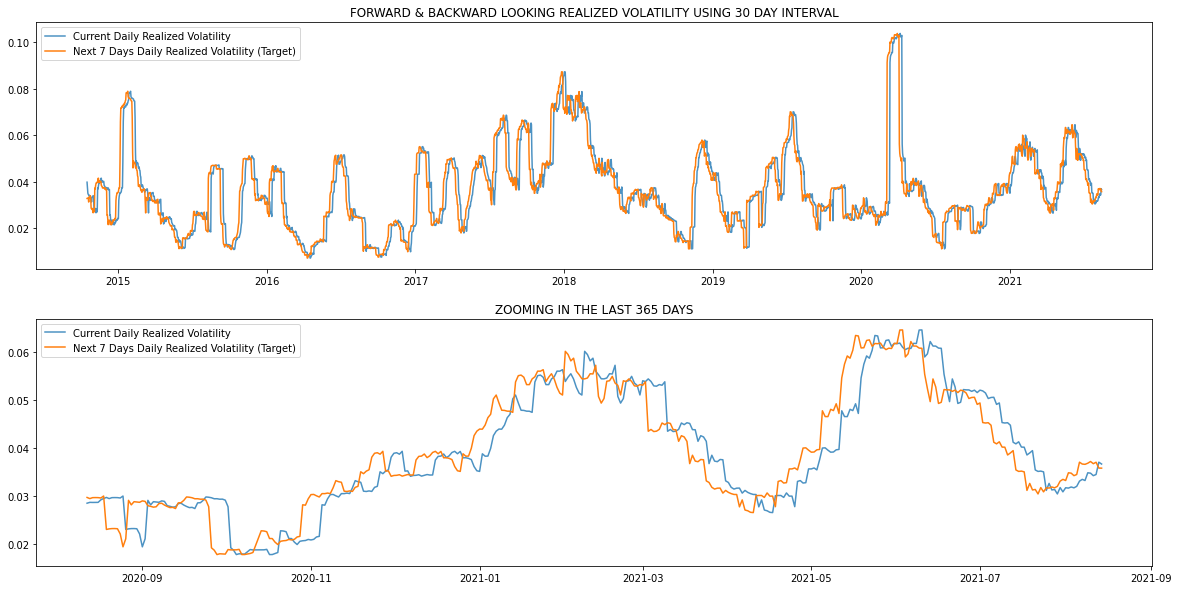

In [494]:
# VISUALIZE REALIZED CURRENT VS. FUTURE VOLATILITY
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20,10))

# ax1.plot(df.log_returns, color='gray', alpha=.4, label='Log Returns')
ax1.plot(df.vol_current, alpha=.8, label='Current Daily Realized Volatility')
ax1.plot(df.vol_future, label=f'Next {n_future} Days Daily Realized Volatility (Target)')

# ax2.plot(df.log_returns[-365:], color='gray', alpha=.4, label='Log Returns')
ax2.plot(df.vol_current[-365:], alpha=.8, label='Current Daily Realized Volatility')
ax2.plot(df.vol_future[-365:], label=f'Next {n_future} Days Daily Realized Volatility (Target)')

ax1.title.set_text(f'FORWARD & BACKWARD LOOKING REALIZED VOLATILITY USING {WINDOW_SIZE} DAY INTERVAL')
ax2.title.set_text('ZOOMING IN THE LAST 365 DAYS')

ax1.legend()
ax2.legend()
plt.show();

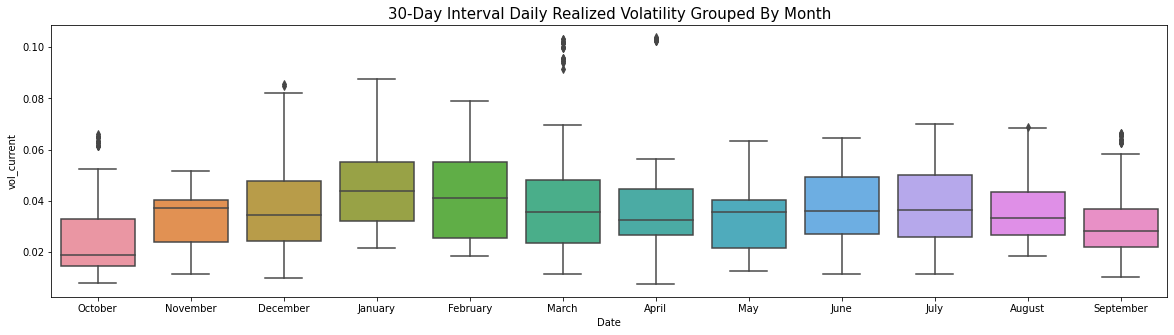

In [495]:
fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(x=df.index.month_name(), y=df.vol_current, ax=ax)
ax.set_title(f'{WINDOW_SIZE}-Day Interval Daily Realized Volatility Grouped By Month', fontsize=15);

Here we can see that the volatility usually fluctuates within a widest range in the months of December and January. March has the most amount of large outliers, while August and Septermber historically has been relatively quiet.

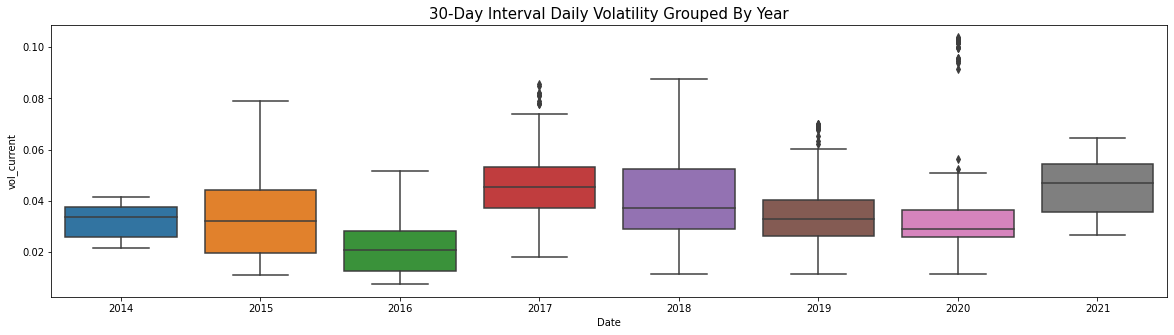

In [496]:
fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(x=df.index.year, y=df.vol_current, ax=ax)
ax.set_title(f'{WINDOW_SIZE}-Day Interval Daily Volatility Grouped By Year', fontsize=15);

This plot does reflect Bitcoin's first record peak in 2017. And the outliers in 2020 corresponded with the surge in 2020. And based on this, 2021's daily volatiliy overall has been on the higher side as well. 

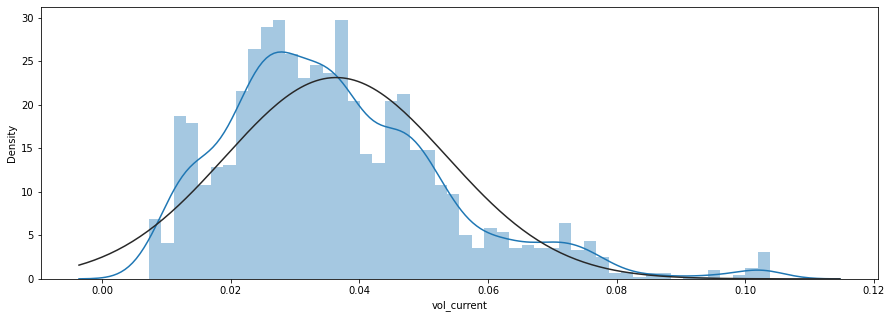

In [497]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(df.vol_current, norm_hist=True, fit=stats.norm,
             bins=50, ax=ax)
plt.show();

The distribution of daily realized volatility is lightly right skewed, with a small number of larger values spreaded thinly on the right.

A skewed right distribution would have smaller median compared to mean, and mode smaller than median (mode < median < mean).

In [34]:
len(df)

2490

In [35]:
df.index

DatetimeIndex(['2014-10-17', '2014-10-18', '2014-10-19', '2014-10-20',
               '2014-10-21', '2014-10-22', '2014-10-23', '2014-10-24',
               '2014-10-25', '2014-10-26',
               ...
               '2021-08-05', '2021-08-06', '2021-08-07', '2021-08-08',
               '2021-08-09', '2021-08-10', '2021-08-11', '2021-08-12',
               '2021-08-13', '2021-08-14'],
              dtype='datetime64[ns]', name='Date', length=2490, freq=None)

In [38]:
100 - 1.2 - 14.7

84.1

### Train-Validation-Test Split

There're a total of 2490 usable datapoints in this dataset which covers a period of almost 7 years from October 2014 until today (August 2021). Since cryptocurrencies are not traded on a regulated exchange, the Bitcoin market is open 24/7, 1 year covers a whole 365 trading days instead of 252 days a year like with other stocks and commodities.

I would split the dataset into 3 parts as follows:
- the most recent 30 usable datapoints would be used for testing - approx. 1.2%
- 1 full year (365 days) for validation - approx. 14.7%
- and the remaining for training - approx. 84.1%




In [39]:
test_size = 30
val_size = 365

split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [48]:
print(f'Training \tFrom: {train_idx[0]} \tto {train_idx[-1]} \t{len(train_idx)} days')
print(f'Validation \tFrom: {val_idx[0]} \tto {val_idx[-1]} \t{len(val_idx)} days')
print(f'Test \t\tFrom: {test_idx[0]} \tto {test_idx[-1]} \t{len(test_idx)} days')

Training 	From: 2014-10-17 00:00:00 	to 2020-07-12 00:00:00 	2095 days
Validation 	From: 2020-07-13 00:00:00 	to 2021-07-15 00:00:00 	365 days
Test 		From: 2021-07-16 00:00:00 	to 2021-08-14 00:00:00 	30 days


In [49]:
# train_idx

In [50]:
# len(train_idx)

In [51]:
# val_idx

In [52]:
# len(val_idx)

In [53]:
# test_idx

In [54]:
# len(test_idx)

The target here would be `df['vol_future']` which represents the daily realized volatility of the next `n_future` days from today (average daily volatility from `t + n_future - WINDOW_SIZE` to time step `t + n_future`). 

For example, using an `n_future` value of 7 and a `WINDOW_SIZE` of 30, the value that I want to predict at time step `t` would be the average daily realized volatility from time step `t-23` to time step `t+7`.

In [55]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS 
# (this would be the target)
y_train = df.vol_future[train_idx]
y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]

In [56]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS 
# (this would be the input for some models)
x_train = df.vol_current[train_idx]
x_val = df.vol_current[val_idx]
x_test = df.vol_current[test_idx]

In [57]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.returns[train_idx]
r_val = df.returns[val_idx]
r_test = df.returns[test_idx]

In [58]:
# SPLIT LOG RETURNS INTO 3 PARTS
lr_train = df.log_returns[train_idx]
lr_val = df.log_returns[val_idx]
lr_test = df.log_returns[test_idx]

As I am going to build various types of models based on different algorithms  with slightly different assumptions using different types of parameters, it's probably better to normalize the volatilities using `MinMaxScaler` to standardize performance comparison among different models.

In [59]:
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT REALIZED VOLATILITY IN TRAINING
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [60]:
# TRANSFORM TRAINING VOLATILITIES 
x_train_scaled = pd.Series(scaler_vol.transform(x_train.values.reshape(-1,1))[:,0],
                           index=train_idx)
y_train_scaled = pd.Series(scaler_vol.transform(y_train.values.reshape(-1,1))[:,0],
                           index=train_idx)

# TRANSFORMING VALIDATION VOLATILITIES
x_val_scaled = pd.Series(scaler_vol.transform(x_val.values.reshape(-1,1))[:,0],
                           index=val_idx)
y_val_scaled = pd.Series(scaler_vol.transform(y_val.values.reshape(-1,1))[:,0],
                           index=val_idx)

# TRANSFORMING TEST VOLATILITIES
x_test_scaled = pd.Series(scaler_vol.transform(x_test.values.reshape(-1,1))[:,0],
                           index=test_idx)
y_test_scaled = pd.Series(scaler_vol.transform(y_test.values.reshape(-1,1))[:,0],
                           index=test_idx)

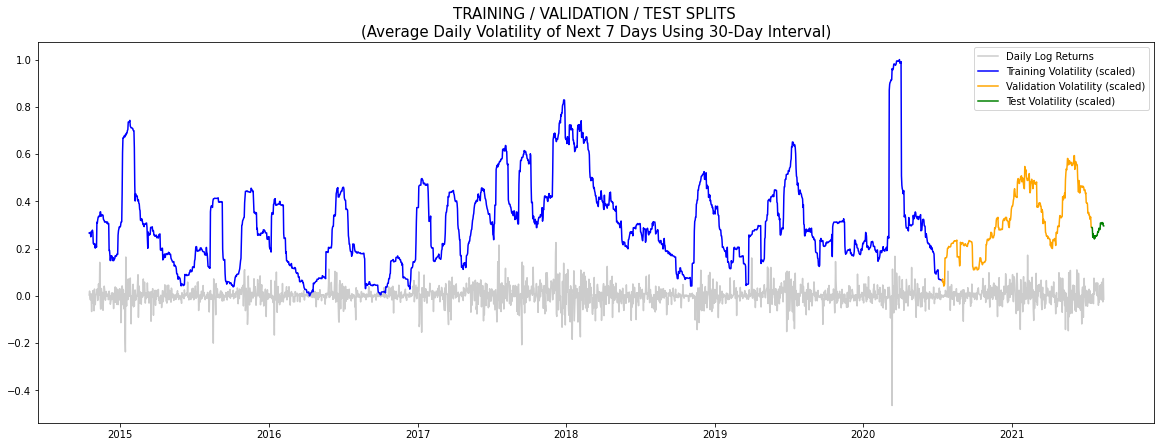

In [65]:
plt.figure(figsize=(20,7))

plt.plot(df.log_returns, color='gray', label='Daily Log Returns', alpha=0.4)

plt.plot(y_train_scaled, color='blue', label='Training Volatility (scaled)')
plt.plot(y_val_scaled, color='orange', label='Validation Volatility (scaled)')
plt.plot(y_test_scaled, color='green', label='Test Volatility (scaled)')

plt.plot()
plt.title(f'TRAINING / VALIDATION / TEST SPLITS \n(Average Daily Volatility of Next {n_future} Days Using {WINDOW_SIZE}-Day Interval)', fontsize=15)
plt.legend()
plt.show();

## Baseline Model

This would be a very simple model that only outputs the average current realized volatility of the whole training set as predictions.

In [62]:
# CALCULATE THE MEAN OF SCALED TRAINING DATA
mean_train_vol = x_train_scaled.mean()
mean_train_vol

0.2987712391707684

In [63]:
# CREATE SERIES OF PREDICTIONS FOR BASELINE MODEL ON VALIDATION SET
baseline_preds = np.ones(len(val_idx)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=lr_val.index)

In [87]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):
    plt.figure(figsize=(20,7))
    plt.plot(y_true, color='blue', 
             label=f"Scaled Next {n_future} days' Daily Volatility (Target)")
    plt.plot(x_val_scaled, color='gray',  ls='--',
             label=f"Scaled Current Daily Volatility")
    plt.plot(lr_val, color='gray', alpha=0.4,
             label='Daily Log Returns')
    plt.plot(y_pred, color='orange', lw=3,
             label=f'Forecasted Volatility')

    plt.title(f'{model_name} \non Validation Data', fontsize=15)
    plt.legend(loc='best');

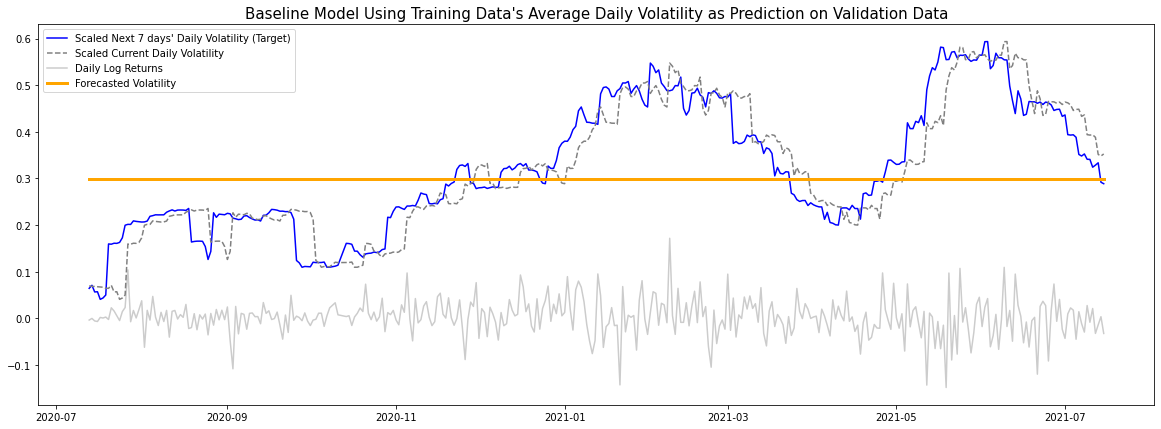

In [67]:
viz_model(y_val_scaled, baseline_preds, 
          f"Baseline Model Using Training Data's Average Daily Volatility as Prediction")

In [68]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [69]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

#### Metrics

The 2 main metrics I'd be using are **RMSPE (Root Mean Squared Percentage Error)** and **RMSE (Root Mean Square Errors)** with RMSPE prioritized. Scaling is very important in the calculation of volatility due to the level of freedom in frequency selection. Therefore I think RMSPE would help capture degree of errors compared to desired target values better than other metrics. Also RMSPE would punish large errors more than regular MAPE (Mean Absolute Percentage Error), which is what I want to do here.

RMSE and RMSPE would be tracked across different models' performance on validation set forecasting to indicate their abilities to generalize on out-of-sample data.

In [70]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [71]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name, 
                                       RMSPE(y_true, y_pred), 
                                       RMSE(y_true, y_pred)]
    return perf_df

In [72]:
log_perf(y_val_scaled, baseline_preds, 'Mean Baseline')

Model  Validation RMSPE  Validation RMSE
0  Mean Baseline          0.835306         0.136594

### Naive Random Walk Forecasting

A commonly known fact about volatility is that it tends to be autocorrelated. This property can be used to implement a naive model that just "predicts" future volatility by using whatever the daily volatility was at the immediate previous time step.

In this case, I'll use the daily volatility of the most recent 7 days as predictions for the next 7 days, which is essentially `vol_current`.

In [73]:
# USING THE PREVIOUS n_future DAY'S VOLATILITY
random_walk_preds = x_val_scaled

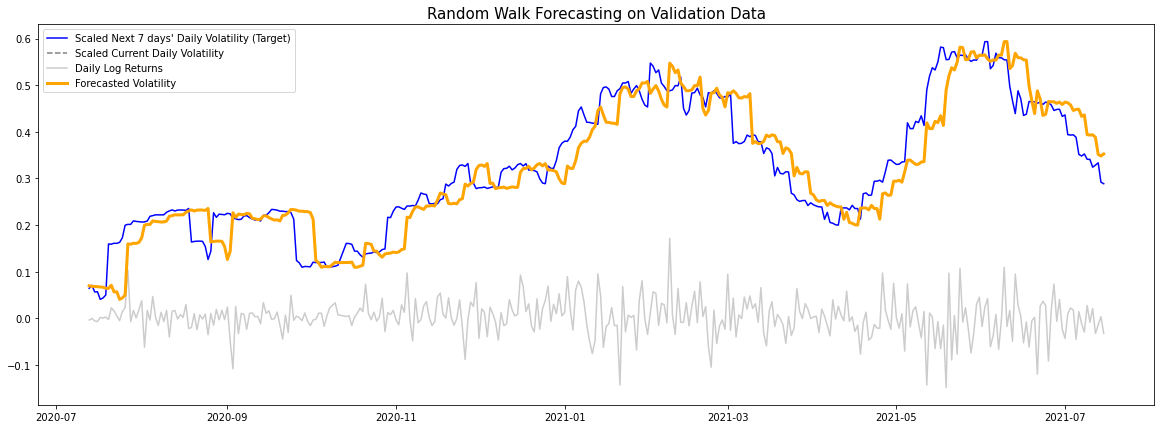

In [74]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, random_walk_preds, 'Random Walk Forecasting')

In [75]:
print('Validation RMSPE:', RMSPE(y_val_scaled, random_walk_preds))

Validation RMSPE: 0.23360829923167634


In [76]:
print('Validation RMSE:', RMSE(y_val_scaled, random_walk_preds))

Validation RMSE: 0.05251737331858845


In [77]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, random_walk_preds, 'Random Walk')

Model  Validation RMSPE  Validation RMSE
0  Mean Baseline          0.835306         0.136594
1    Random Walk          0.233608         0.052517

So the both error mertrics have gone down by a decent amount. Naive forecasting in time series is sometimes surprisingly difficult to outperform.

### GARCH Model

(Source: Sinclair)

GARCH Model is the traditional econometric approach to volatility prediction of financial time series.

GARCH(1,1) only contains first-order lagged terms and the mathematic equation for it is: 


$\sigma^2_t = \omega + \alpha\epsilon^{2}_{(t-1)} + \beta\sigma^{2}_{(t-1)}$

where $\alpha$, $\beta$ and $\omega$ sum up to 1, and $\omega$ is the long term variance.

GARCH is generally regarded as an insightful improvement on naively assuming future volatility will be like the past, but also considered widely overrated as predictor by some experts in the field of volatility. GARCH models capture the essential characteristics of volatility: volatility tomorrow will be close to what it is today (**clustering**), and volatility in the long term will probably **mean revert** (meaning it'd be close to whatever the historical long-term average has been).

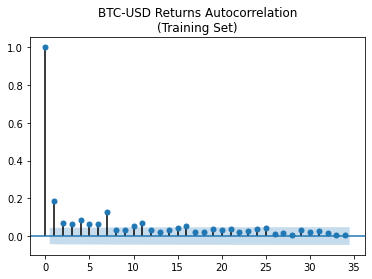

In [78]:
# VISUALIZE AUTOCORRELATION OF SQUARED RETURNS
plot_acf(r_train**2, 
          title=f'{tckr.upper()} Returns Autocorrelation\n(Training Set)');

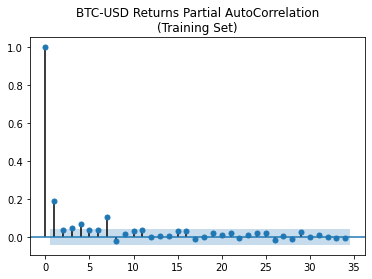

In [79]:
# VISUALIZE PARTIAL AUTOCORRELATION OF SQUARED RETURNS
plot_pacf(r_train**2, 
          title=f'{tckr.upper()} Returns Partial AutoCorrelation\n(Training Set)');

The autocorrelation plots seem to indicate that there's only significant correlation up to the 7th lags, and the ones following don't seem to be too significant.

GARCH models are trained on percent returns. One of the reasons I decided to normalize the volatilities across the board is because I am still not 100% sure which timeframe/frequency/interval GARCH conditional volatility is calculated in (likely daily), and still haven't figured out why the outputs here seem to be on a totally different scale compared to the volatilities previously calculated. Once I scale them, they match up much more nicely.

In [80]:
from arch import arch_model

In [81]:
gm_1 = arch_model(r_train, p=7, q=7,
                  dist='normal')
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5588.19
Distribution:                  Normal   AIC:                           11208.4
Method:            Maximum Likelihood   BIC:                           11298.7
                                        No. Observations:                 2095
Date:                Sat, Aug 21 2021   Df Residuals:                     2094
Time:                        15:41:09   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1785      0.112      1.598      0.110 [-4.0

Using a significant level of 0.05, none of the coefficients seems to be statistically significant. Therefore, I'll reduce the values of `p` and `q` to 1 to see if that helps.

In [82]:
gm_1 = arch_model(r_train, vol='GARCH', p=1, q=1,
                  dist='normal')
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5604.29
Distribution:                  Normal   AIC:                           11216.6
Method:            Maximum Likelihood   BIC:                           11239.2
                                        No. Observations:                 2095
Date:                Sat, Aug 21 2021   Df Residuals:                     2094
Time:                        15:41:25   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2001  6.704e-02      2.985  2.835e-03 [6.872e-

All coefficients look statistically significant now.

After being fitted to the training data (percent returns), the GARCH model outputs conditional volatility for the training portion of the time series. I am going to scale the fitted conditional volatility arrays, plot it out and compare it to the realized volatility calculated above (also scaled) `x_train_scaled`.

In [83]:
scaler_garch_vol = MinMaxScaler()

cond_vol_arr = result_1.conditional_volatility.values.reshape(-1,1)

# FITTING SCALER TO MODEL'S CONDITIONAL VOLATILITY
scaler_garch_vol = scaler_garch_vol.fit(cond_vol_arr)
scaled_cond_vol = pd.Series(scaler_garch_vol.transform(cond_vol_arr)[:,0],
                            index=train_idx)

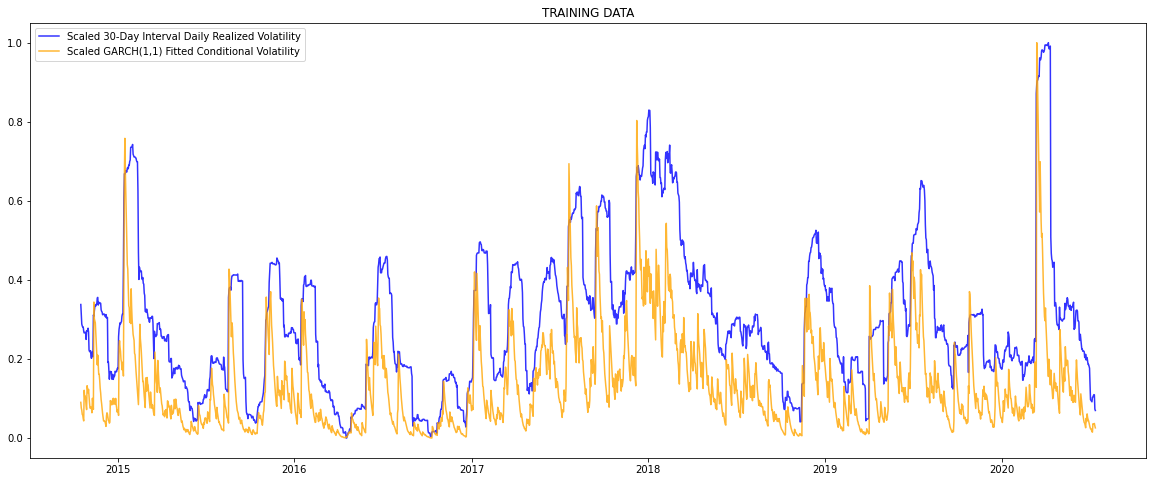

In [85]:
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(x_train_scaled, color='blue', alpha=0.8,
        label=f'Scaled {WINDOW_SIZE}-Day Interval Daily Realized Volatility')
ax.plot(scaled_cond_vol, color='orange', alpha=0.8,
        label='Scaled GARCH(1,1) Fitted Conditional Volatility')
ax.set_title('TRAINING DATA')
plt.legend()
plt.show();

#### Analytical-based Forecasting

The volatility forecasts from the GARCH models using percent returns as input are on a totally different scale compared to the volatilities calculated from log returns. Therefore I am going to normalize the forecasted volatility based on the model's `conditional_volatility` output from the training data, and only comparing the scaled versions of volatilities on the Validation set.

In [86]:
# ROLLING FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx]
    # from_idx = idx[split_time_1 + i - WINDOW_SIZE]
    # to_idx = idx[split_time_1 + i - 1]
    
    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # OR FIXED ROLLING WINDOW FITTING
    # model_fit = model.fit(disp='off', first_obs=from_idx, last_obs=to_idx)

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=val_idx)

In [88]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = pd.Series(scaler_garch_vol.transform(np.array(rolling_forecasts).reshape(-1,1))[:,0], 
                              index=val_idx)

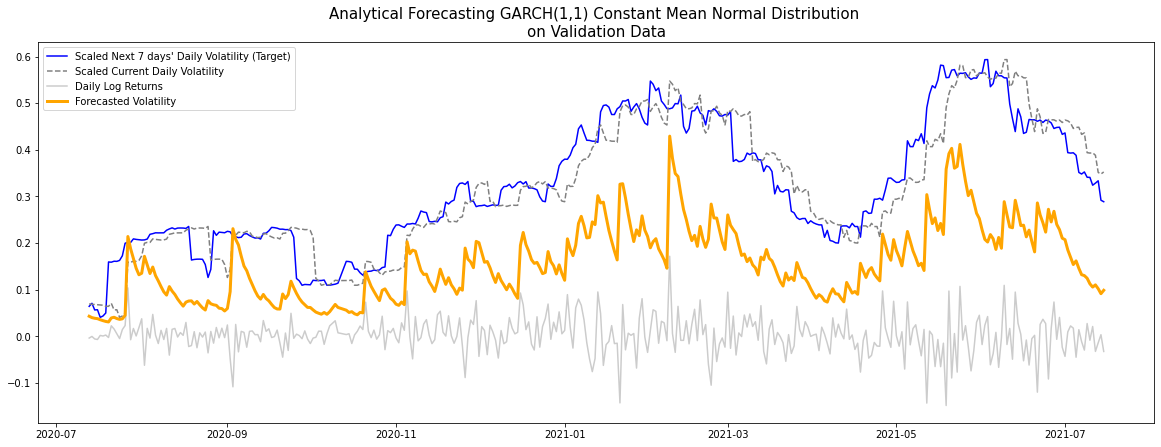

In [89]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gm_1_preds_scaled, 
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')

So 7-day horizon forecasting is still lagging behind compared to target values. Similar to the training volatilities comparison above, GARCH's forecasted volatility appears to be lower side (after normalization).

In [90]:
print('Validation RMSPE:', RMSPE(y_val_scaled, gm_1_preds_scaled))

Validation RMSPE: 0.5338429559269549


In [91]:
print('Validation RMSE:', RMSE(y_val_scaled, gm_1_preds_scaled))

Validation RMSE: 0.18529406771591087


In [92]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_1_preds_scaled, 'GARCH(1,1) | Constant Mean | Normal Dist')

Model  Validation RMSPE  Validation RMSE
0                             Mean Baseline          0.835306         0.136594
1                               Random Walk          0.233608         0.052517
2  GARCH(1,1) | Constant Mean | Normal Dist          0.533843         0.185294

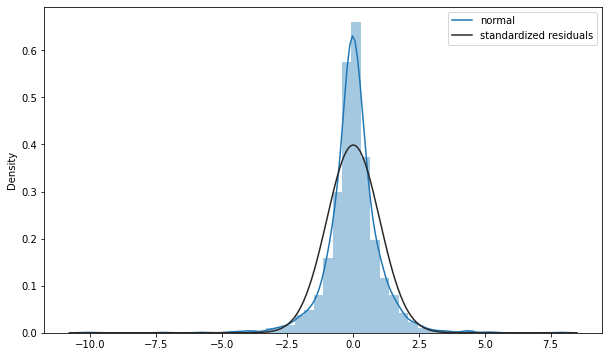

In [93]:
# INSPECTING THE RESIDUALS
gm_resid = result_1.resid
gm_std = result_1.conditional_volatility

# STANDARDIZING RESIDUALS
gm_std_resid = gm_resid / gm_std

# VISUALIZING STANDARDIZED RESIDUALS VS. A NORMAL DISTRIBUTION
plt.figure(figsize=(10,6))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)
plt.legend(('normal', 'standardized residuals'))
plt.show();

Ref: https://goldinlocks.github.io/ARCH_GARCH-Volatility-Forecasting/

"GARCH models make distribution assumptions about the residuals and the mean return. Financial time series data often does not follow a normal distribution. In financial time series it is much more likely to observe extreme positive and negative values that are far away from the mean. to improve a GARCH models distribution assumptions to be more representative of real financial data we can specify the models distribution assumption to be a Student's t-distribution. A Student's t-distribution is symmetric and bell shaped similar to a normal distribution but has fatter tails making it more prone to producing values that fall far away from its mean. The nu  (𝜈)  parameter indicates its shape the larger the  𝜈  the more peaked the curve becomes.

GARCH models enable one to specify the distribution assumptions of the standardized residuals. By default, a normal distribution is assumed, which has a symmetric, bell-shaped probability density curve. Other options include Student's t-distribution and skewed Student's t-distribution."

Looking at the plot above of the standardized residuals, I think I can try skewed Student's T for the next fit.

### GARCH Models with Asymmetric Shocks Responses

The basic GARCH model assumes positive and negative news have similar impact on volatility. However, in reality the market tends to "take the stairs up and the elevator down." In other words, the impact is usually asymmetric, and negative returns tends to affect the volatility more than positive ones.

There's another member in the GARCH family that accounts for assymmetry of shocks reponses called **GJR-GARCH** (short for Glosten-Jagannathan-Runkle GARCH).

Additional inputs can be used to construct other models. In this case, by setting `o` to 1, which means the model would include one lag of an asymmetric shock which transforms a GARCH model into a GJR-GARCH model with variance dynamics.


In [94]:
gjr_gm = arch_model(r_train, p=1, q=1, o=1, 
                    vol='GARCH', dist='skewt')

In [95]:
result_2 = gjr_gm.fit(disp='off')
print(result_2.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -5272.69
Distribution:      Standardized Skew Student's t   AIC:                           10559.4
Method:                       Maximum Likelihood   BIC:                           10598.9
                                                   No. Observations:                 2095
Date:                           Sat, Aug 21 2021   Df Residuals:                     2094
Time:                                   15:51:44   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

Log-likelihood has increased quite a bit. Let's see how the conditional volatility looks.

In [96]:
scaler_gjr_garch_vol = MinMaxScaler()

gjr_cond_vol_arr = result_2.conditional_volatility.values.reshape(-1,1)

# FITTING SCALER TO MODEL'S CONDITIONAL VOLATILITY
scaler_gjr_garch_vol = scaler_gjr_garch_vol.fit(gjr_cond_vol_arr)
scaled_gjr_cond_vol = pd.Series(scaler_gjr_garch_vol.transform(gjr_cond_vol_arr)[:,0],
                                index=train_idx)

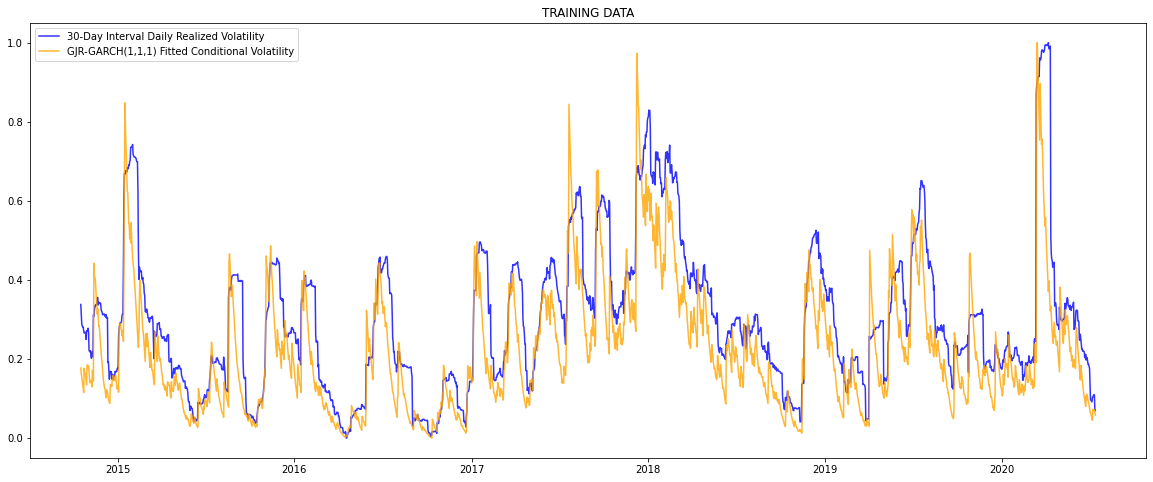

In [100]:
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(x_train_scaled, color='blue', alpha=0.8,
        label=f'{WINDOW_SIZE}-Day Interval Daily Realized Volatility')
ax.plot(scaled_gjr_cond_vol, color='orange', alpha=0.8,
        label='GJR-GARCH(1,1,1) Fitted Conditional Volatility')
ax.set_title('TRAINING DATA')
plt.legend()
plt.show();

In [101]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1, 
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gjr_gm_1_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [102]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_gm_1_preds_scaled = pd.Series(scaler_gjr_garch_vol.transform(np.array(rolling_forecasts).reshape(-1,1))[:,0], 
                                  index=val_idx)

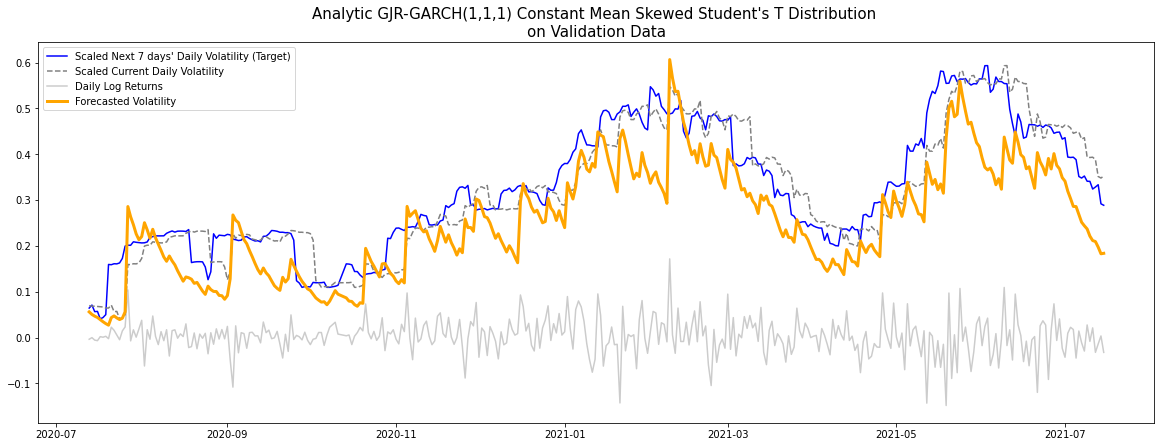

In [103]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gjr_gm_1_preds_scaled, 
          "Analytic GJR-GARCH(1,1,1) Constant Mean Skewed Student's T Distribution")

In [104]:
RMSPE(y_val_scaled, gjr_gm_1_preds_scaled)

0.28667367964729656

In [105]:
RMSE(y_val_scaled, gjr_gm_1_preds_scaled)

0.0911152307646847

In [106]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gjr_gm_1_preds_scaled, 
         "Analytic GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist")

Model  ...  Validation RMSE
0                                           Mean Baseline  ...         0.136594
1                                             Random Walk  ...         0.052517
2                GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185294
3  Analytic GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091115

[4 rows x 3 columns]

### TARCH 

Source: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html#Specifying-Common-Models
TARCH (also known as ZARCH) model the volatility using absolute values. This model is specified using `power=1.0` since the default power, 2, corresponds to variance processes that evolve in squares.

In [107]:
t_gm = arch_model(r_train, p=1, o=1, q=1, power=1.0,
                  dist='skewt')

In [108]:
result_3 = gjr_gm.fit(disp='off')
print(result_3.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -5272.69
Distribution:      Standardized Skew Student's t   AIC:                           10559.4
Method:                       Maximum Likelihood   BIC:                           10598.9
                                                   No. Observations:                 2095
Date:                           Sat, Aug 21 2021   Df Residuals:                     2094
Time:                                   15:57:50   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

Log likelihood went up by a bit.

In [109]:
scaler_tarch_vol = MinMaxScaler()

tarch_cond_vol_arr = result_3.conditional_volatility.values.reshape(-1,1)

# FITTING SCALER TO MODEL'S CONDITIONAL VOLATILITY
scaler_tarch_vol = scaler_tarch_vol.fit(tarch_cond_vol_arr)
scaled_tarch_cond_vol = pd.Series(scaler_tarch_vol.transform(tarch_cond_vol_arr)[:,0],
                             index=train_idx)

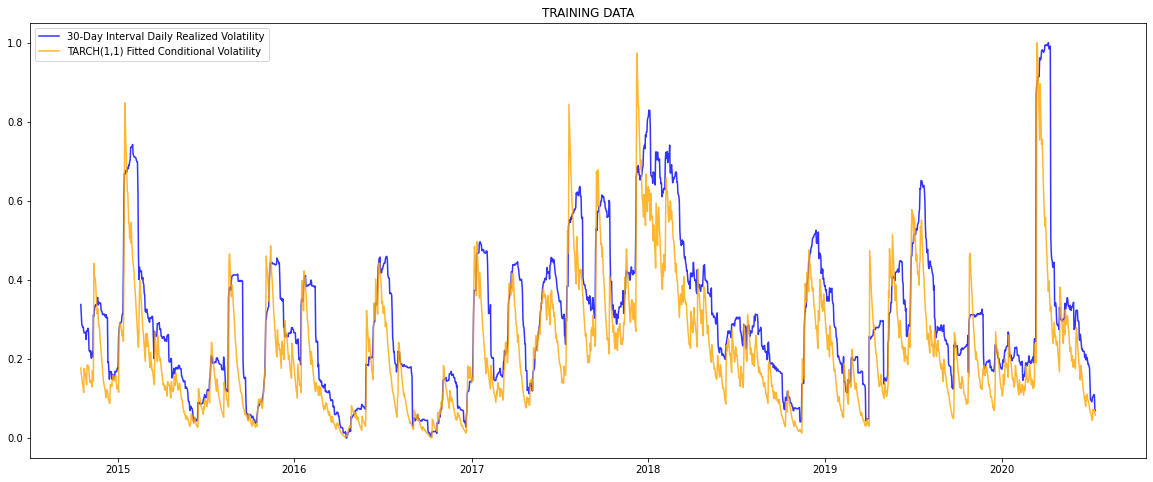

In [110]:
fig, ax = plt.subplots(figsize=(20,8))

ax.plot(x_train_scaled, color='blue', alpha=0.8,
        label=f'{WINDOW_SIZE}-Day Interval Daily Realized Volatility')
ax.plot(scaled_tarch_cond_vol, color='orange', alpha=0.8,
        label='TARCH(1,1) Fitted Conditional Volatility')
ax.set_title('TRAINING DATA')
plt.legend()
plt.show();

Source: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html#TARCH

TARCH models do not have closed-form (analytical) forecasts for horizons larger than 1, and so simulation or bootstrapping is required.

In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_gm_1_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [112]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_gm_1_preds_scaled = pd.Series(scaler_tarch_vol.transform(np.array(rolling_forecasts).reshape(-1,1))[:,0], 
                                  index=val_idx)

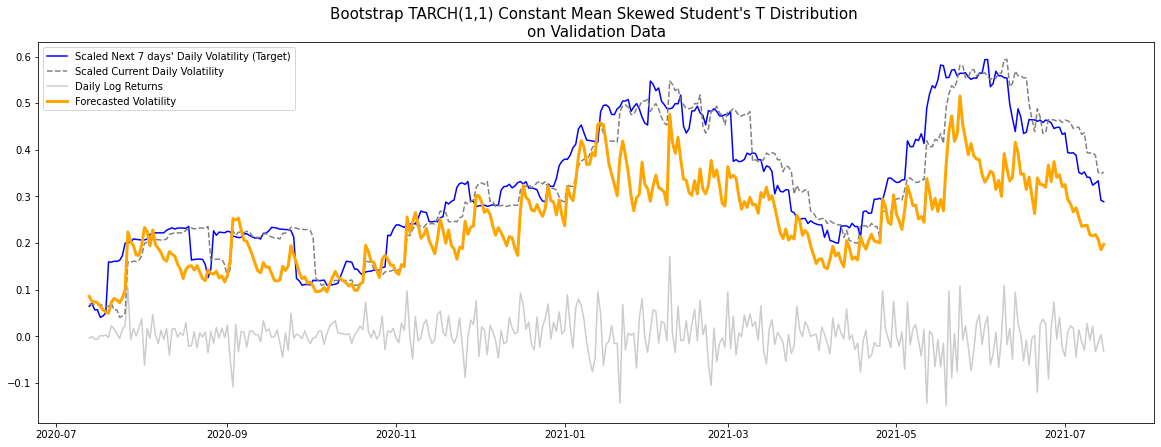

In [113]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_gm_1_preds_scaled, 
          "Bootstrap TARCH(1,1) Constant Mean Skewed Student's T Distribution")

In [114]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_gm_1_preds_scaled, 
         "Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist")

Model  ...  Validation RMSE
0                                           Mean Baseline  ...         0.136594
1                                             Random Walk  ...         0.052517
2                GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185294
3  Analytic GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091115
4       Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.104548

[5 rows x 3 columns]

Between the 3 versions of GARCH, GJR-GARCH(1,1,1) has the lower RMSE and RMSPE on the validation set. Therefore, I'll try different types of Forecasting Method on GJR-GARCH next to see if that'd help improve output accuracy.

#### Simulation-based Forecasting for GJR-GARCH(1,1,1)

In [115]:
# ROLLING FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(r_val)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1,
                       mean='Constant', vol='GARCH', 
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION 
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='simulation').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gjr_gm_1_sm_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [116]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_gm_1_sm_preds_scaled = pd.Series(scaler_gjr_garch_vol.transform(np.array(rolling_forecasts).reshape(-1,1))[:,0], 
                                    index=val_idx)

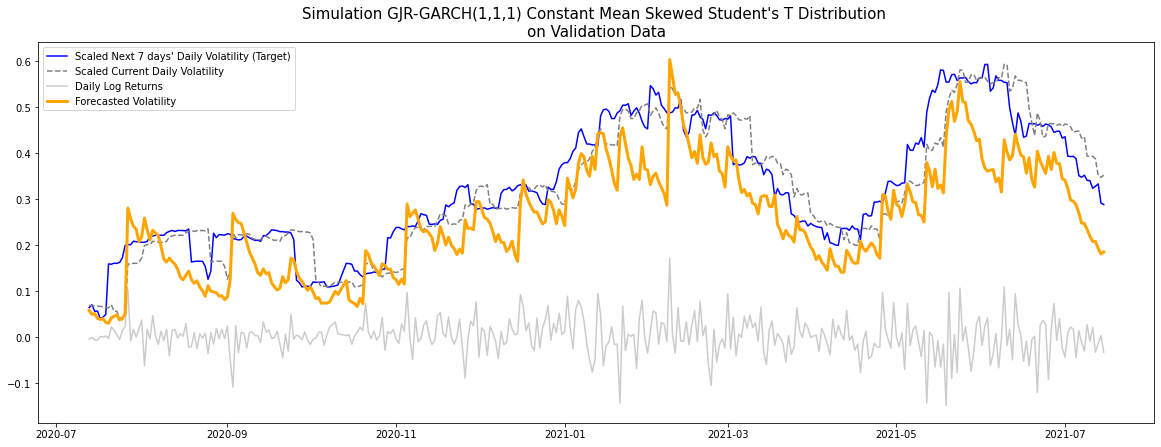

In [117]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gjr_gm_1_sm_preds_scaled, 
          "Simulation GJR-GARCH(1,1,1) Constant Mean Skewed Student's T Distribution")

In [118]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gjr_gm_1_sm_preds_scaled, 
         "Simulation GJR-GARCH(1,1,1) | Constant Mean | skewt dist")

Model  ...  Validation RMSE
0                                             Mean Baseline  ...         0.136594
1                                               Random Walk  ...         0.052517
2                  GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185294
3    Analytic GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091115
4         Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.104548
5  Simulation GJR-GARCH(1,1,1) | Constant Mean | skewt dist  ...         0.091578

[6 rows x 3 columns]

#### Bootstrap-based Forecasting

Ref: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html 

Bootstrap-based forecasts are nearly identical to simulation-based forecasts except that the values used to simulate the process are computed from historical data rather than using the assumed distribution of the residuals. Forecasts produced using this method also return an ARCHModelForecastSimulation containing information about the simulated paths.

In [119]:
# ROLLING FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(r_val)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1,
                       mean='Constant', vol='GARCH', 
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION 
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gjr_gm_1_bs_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [120]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_gm_1_bs_preds_scaled = pd.Series(scaler_gjr_garch_vol.transform(np.array(rolling_forecasts).reshape(-1,1))[:,0], 
                                     index=val_idx)

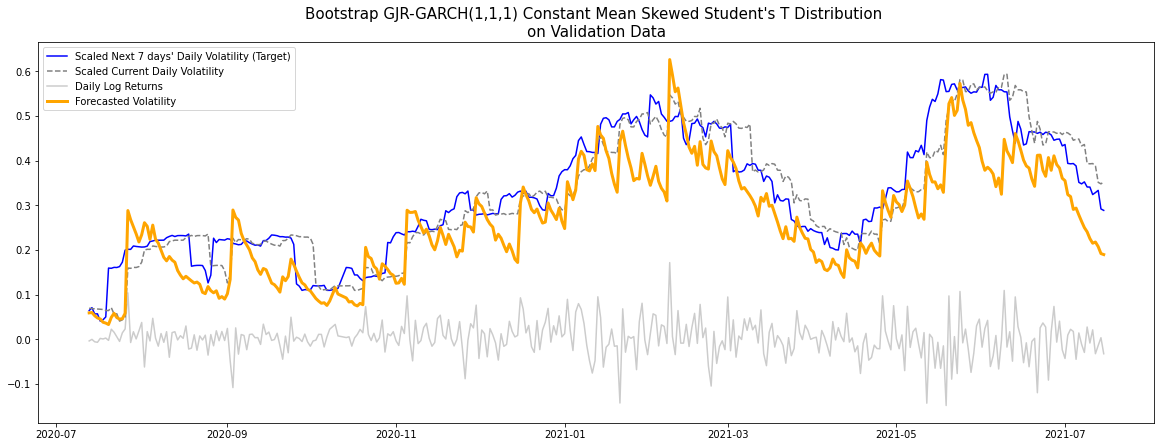

In [121]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gjr_gm_1_bs_preds_scaled, 
         "Bootstrap GJR-GARCH(1,1,1) Constant Mean Skewed Student's T Distribution")

In [122]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gjr_gm_1_bs_preds_scaled, 
         'Bootstrap GJR-GARCH(1,1,1) | Constant Mean | skewt Dist')

Model  ...  Validation RMSE
0                                             Mean Baseline  ...         0.136594
1                                               Random Walk  ...         0.052517
2                  GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185294
3    Analytic GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091115
4         Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.104548
5  Simulation GJR-GARCH(1,1,1) | Constant Mean | skewt dist  ...         0.091578
6   Bootstrap GJR-GARCH(1,1,1) | Constant Mean | skewt Dist  ...         0.083858

[7 rows x 3 columns]

Using RMSPE on validation set as the main metric, so far Bootstrap GJR-GARCH(1,1,1) with Constant Mean and Skewed Student's T Distribution seems to be performing the best, yet still not better than Naive Random Walk Forecasting.

### p/q/o Tuning

Next, I'll create a range of values for p, q and o from 0 to 3 (inclusive)
, and then record each's model's performance on unseen data using RMSPE. Since p cannot take a value of 0, we'll eliminate that from our list of permutations. 

In [123]:
import itertools

In [124]:
pqo_s = [p for p in itertools.product(range(3), repeat=3)]
# ELIMINATE PERMUTATIONS WITH p = 0
pqo_s = list(filter(lambda x: x[0] != 0, pqo_s))
rmspe_s = []
llh_s = []
bic_s = []

for p, q, o in pqo_s:
    # FITTING GJR-GARCH(p,q,o) MODEL
    gm_pq = arch_model(r_train, p=p, q=q, o=o, 
                       vol='GARCH', dist='skewt',
                       mean='constant')
    gm_pq_fit = gm_pq.fit(disp='off')

    # SCALING CONDITIONAL VOLATILITY OUTPUTS
    sclr = MinMaxScaler()
    gm_cond_vol_arr = gm_pq_fit.conditional_volatility.values.reshape(-1,1)

    # FITTING SCALER TO MODEL'S CONDITIONAL VOLATILITY
    sclr = sclr.fit(gm_cond_vol_arr)
    # scaled_gm_cond_vol = pd.Series(sclr.transform(gm_cond_vol_arr)[:,0],
    #                                index=train_idx)

    # INITIALIZING rolling_forecasts VALUES LIST
    rolling_forecasts = []

    # ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
    for i in range(len(r_val)):
        # GET THE DATA AT ALL PREVIOUS TIME STEPS
        idx = val_idx[i]
        train = df.returns[:idx].dropna()

        # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
        model = arch_model(train, p=p, q=q, o=o, 
                           vol='GARCH', dist='skewt',
                           mean='constant')
        model_fit = model.fit(disp='off')

        # MAKE PREDICTION
        vaR = model_fit.forecast(horizon=n_future, 
                                 reindex=False,
                                 method='bootstrap').variance.values
        pred = np.sqrt(np.mean(vaR))

        # APPEND TO rolling_forecasts LIST
        rolling_forecasts.append(pred)

    # TRANSFORM PREDICTIONS USING FITTED SCALER FOR SPECIFIC p/q/o SET
    y_preds_scaled = pd.Series(sclr.transform(np.array(rolling_forecasts).reshape(-1,1))[:,0], 
                               index=val_idx)
    
    # APPENDING PERFORMANCE METRICS TO LISTS
    llh_s.append(gm_pq_fit.loglikelihood)
    bic_s.append(gm_pq_fit.bic)
    rmspe_s.append(RMSPE(y_val_scaled, y_preds_scaled))

In [125]:
# GET THE VALUES OF p/q THAT YIELDS LOWEST RMSPE
print(f'Lowest RMSPE is {np.min(rmspe_s)} using GARCH{pqo_s[np.argmin(rmspe_s)]}')

Lowest RMSPE is 0.265085138210984 using GARCH(1, 1, 1)


In [126]:
best_pqo = pqo_s[np.argmin(rmspe_s)]

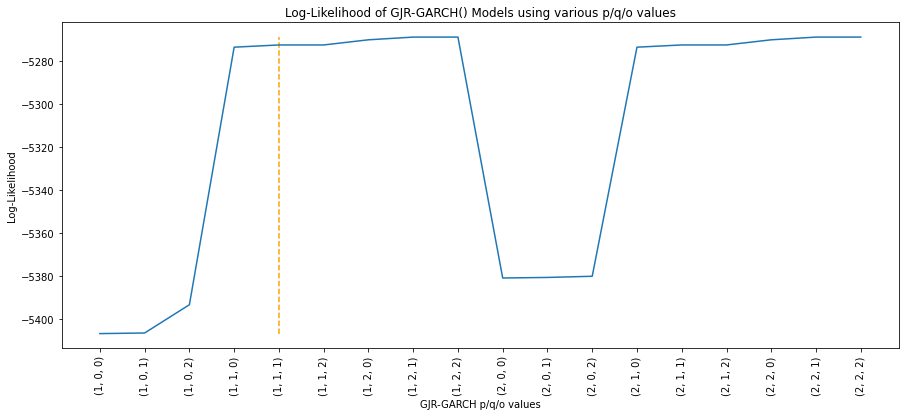

In [127]:
plt.figure(figsize=(15,6))
plt.plot([str(v) for v in pqo_s], llh_s)
plt.xticks(rotation=90)

plt.vlines(x=str(best_pqo), 
           ls='--', color='orange',
           ymin=np.min(llh_s), ymax=np.max(llh_s))

plt.xlabel('GJR-GARCH p/q/o values')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood of GJR-GARCH() Models using various p/q/o values')
plt.show();

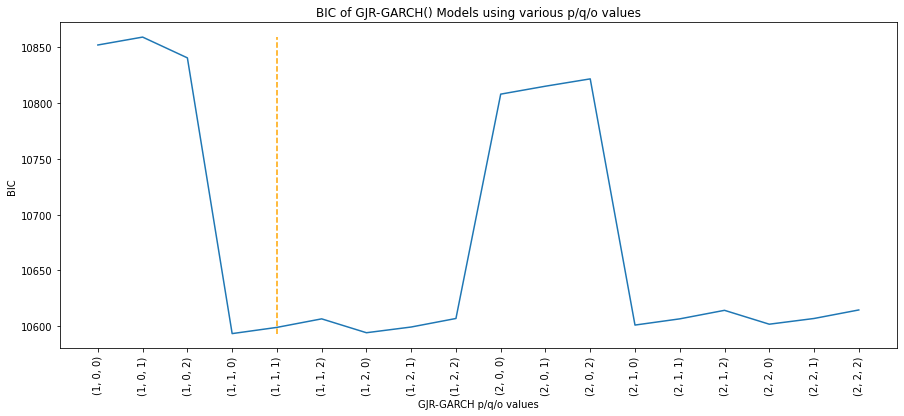

In [128]:
plt.figure(figsize=(15,6))
plt.plot([str(v) for v in pqo_s], bic_s)
plt.xticks(rotation=90)

plt.vlines(x=str(best_pqo), 
           ls='--', color='orange',
           ymin=np.min(bic_s), ymax=np.max(bic_s))

plt.xlabel('GJR-GARCH p/q/o values')
plt.ylabel('BIC')
plt.title('BIC of GJR-GARCH() Models using various p/q/o values')
plt.show();

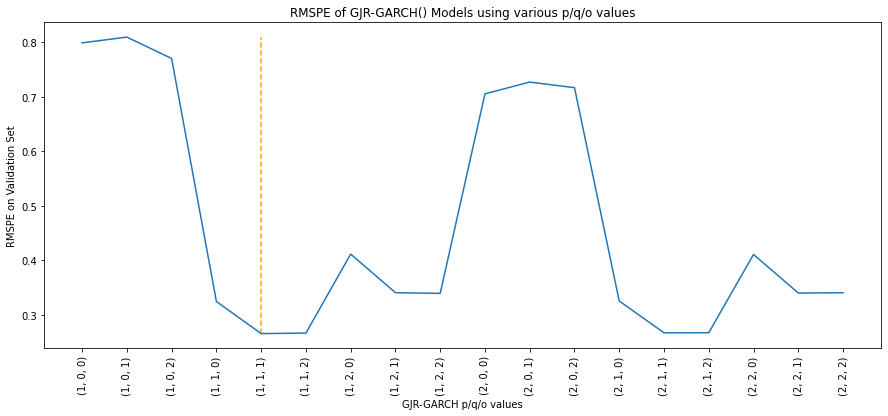

In [129]:
plt.figure(figsize=(15,6))
plt.plot([str(v) for v in pqo_s], rmspe_s)
plt.xticks(rotation=90)

plt.vlines(x=str(best_pqo), 
           ls='--', color='orange',
           ymin=np.min(rmspe_s), ymax=np.max(rmspe_s))

plt.xlabel('GJR-GARCH p/q/o values')
plt.ylabel('RMSPE on Validation Set')
plt.title('RMSPE of GJR-GARCH() Models using various p/q/o values')
plt.show();

So it seems GJR-GARCH(1,1,1) already yields lowest RMPSE on validation set among all the variants I've tried.

## Neural Networks

In [130]:
import tensorflow as tf

In [110]:
# def windowed_dataset(x_series, y_series, lookback_window, batch_size, shuffle_buffer):
#     # PAST VOLATILITY
#     ds_x = tf.data.Dataset.from_tensor_slices(x_series)
#     ds_x = ds_x.window(lookback_window, shift=1, drop_remainder=True)
#     b_x = ds_x.flat_map(lambda w: w.batch(lookback_window))

#     # LOOK FORWARD VOLATILITY 
#     # SKIPPING FORWARD TO WHERE THE PREDICTION SHOULD START
#     ds_y = tf.data.Dataset.from_tensors(y_series[lookback_window:]).unbatch()
#     b_y = ds_y.batch(1)

#     zipped = tf.data.Dataset.zip((b_x, b_y)).map(lambda x, y: tf.concat((x, y), axis=0))

#     dataset = zipped.shuffle(shuffle_buffer).map(lambda w: (w[:-1], w[-1]))
#     dataset = dataset.batch(batch_size).prefetch(1)

#     return dataset

In [174]:
# CONVERT AN SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        from_idx = x_series.index[i-lookback_window+1]
        to_idx = x_series.index[i]
        a = x_series[from_idx:to_idx].values
        dataX.append(a)
        dataY.append(y_series[to_idx])

    return np.array(dataX), np.array(dataY)

In [184]:
from keras import backend as K

In [185]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays
    that can be used as metrics for NN during training
    '''
    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

In [258]:
def val_forecast(model):
    forecast = []
    idx = df.index

    # ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
    for i in range(len(val_idx)):
        # GET THE DATA AT THE PREVIOUS n_past TIME STEPS
        # (including current value)
        from_idx = idx[split_time_1 + i - n_past + 1]
        to_idx = idx[split_time_1 + i]
        pred = model.predict(df.vol_current[from_idx:to_idx].values[np.newaxis])
        forecast.append(pred)

    forecast = np.array(forecast)[:, 0, 0]
    preds = pd.Series(forecast, index=val_idx)

    preds_scaled = pd.Series(scaler_vol.transform(preds.values.reshape(-1,1))[:,0],
                                index=val_idx)
    return preds_scaled

In [ ]:
def viz_train_val_metrics(model_hist):
    fig, ax = plt.subplots(figsize=(20,8))

    # PLOT MSE - LEFT Y-AXIS
    # TRAINING
    ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                model_hist.history['loss'], color='lightblue',
                label='Training MSE')
    # VALIDATION
    ln12 = ax.plot(range(len(model_hist.history['loss'])), 
                model_hist.history['val_loss'], color='darkblue',
                label='Validation MSE')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE')

    # PLOT RMSE - RIGHT Y-AXIS
    ax2 = ax.twinx()
    ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                model_hist.history['rmspe'], color='pink',
                label='Training RMSPE')
    ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                model_hist.history['val_rmspe'], color='red',
                label='Validation RMSPE')
    ax2.set_ylabel('RMSPE')

    # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
    lns = ln11 + ln12 + ln21 + ln22
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='best')

    ax.set_title('Training vs. Validation Metrics', fontsize=15)
    plt.show();

### Neural Network Baseline Metrics - Fully Connected Network

This is essentially Linear Regression.

(Training directly using scaled volatility produces `inf` RMSPE, so I'll stick with the original volatility, and scale the forecasts later).

In [248]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

snn_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[n_past, 1]),                          
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

snn_1.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe])

print(snn_1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 14)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
None


In [249]:
# FIT MODEL TO TRAINING DATASET
snn_1_res = snn_1.fit(mat_X_train, mat_y_train, epochs=100, verbose=1,
                      validation_data=(mat_X_val, mat_y_val),
                      batch_size=batch_size, shuffle=True)

Epoch 1/100
33/33 [==============================] - 1s 6ms/step - loss: 0.0015 - rmspe: 0.9027 - val_loss: 3.0223e-04 - val_rmspe: 0.3700
Epoch 2/100
33/33 [==============================] - 0s 2ms/step - loss: 2.5378e-04 - rmspe: 0.6876 - val_loss: 1.2241e-04 - val_rmspe: 0.3178
Epoch 3/100
33/33 [==============================] - 0s 2ms/step - loss: 2.1537e-04 - rmspe: 0.7347 - val_loss: 1.0803e-04 - val_rmspe: 0.2899
Epoch 4/100
33/33 [==============================] - 0s 2ms/step - loss: 1.8647e-04 - rmspe: 0.6442 - val_loss: 9.2203e-05 - val_rmspe: 0.2685
Epoch 5/100
33/33 [==============================] - 0s 2ms/step - loss: 1.6237e-04 - rmspe: 0.5932 - val_loss: 7.8605e-05 - val_rmspe: 0.2477
Epoch 6/100
33/33 [==============================] - 0s 2ms/step - loss: 1.4187e-04 - rmspe: 0.5333 - val_loss: 6.5296e-05 - val_rmspe: 0.2304
Epoch 7/100
33/33 [==============================] - 0s 2ms/step - loss: 1.2531e-04 - rmspe: 0.4989 - val_loss: 5.7493e-05 - val_rmspe: 0.2123
Epo

In [259]:
snn_1_preds_scaled = val_forecast(snn_1)

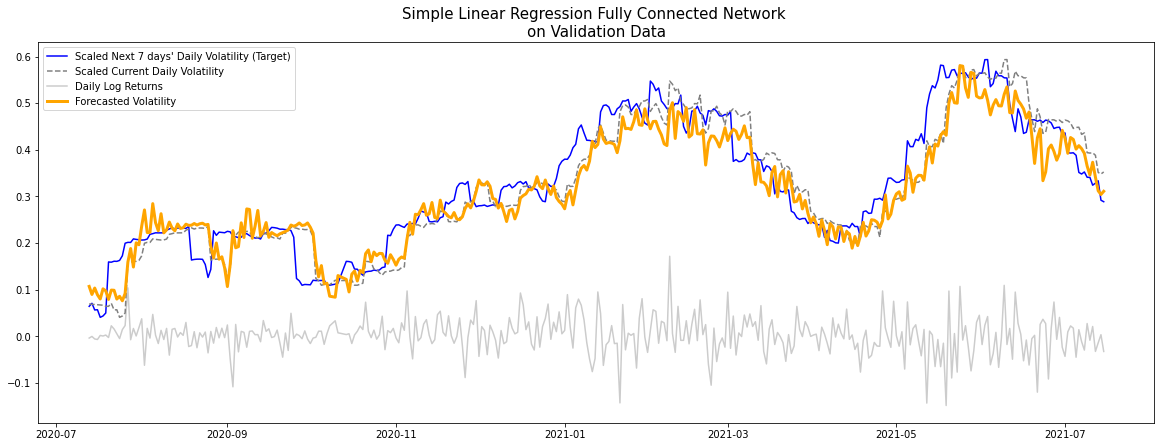

In [260]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, snn_1_preds_scaled, 
          "Simple Linear Regression Fully Connected Network")

In [263]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_1_preds_scaled,
         f"Simple LR Fully Connected NN | n_past={n_past}")

Model  ...  Validation RMSE
0                                             Mean Baseline  ...         0.136594
1                                               Random Walk  ...         0.052517
2                  GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185294
3    Analytic GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091115
4         Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.104548
5  Simulation GJR-GARCH(1,1,1) | Constant Mean | skewt dist  ...         0.091578
6   Bootstrap GJR-GARCH(1,1,1) | Constant Mean | skewt Dist  ...         0.083858
7                  Simple LR Fully Connected NN | n_past=14  ...         0.054558

[8 rows x 3 columns]

A simple Fully Connected NN doesn't perform too bad. Validation RMSPE after 100 epochs of training and barely any tuning is only a bit higher than best GARCH model found, and RMSE is also lower. The forecast actually syncs up with the current volatility, and a bit behind the target that I want.

### Long Short-Term Memory (LSTM) - Univariate

Source: Hands-on Machine Learning... - A. Geron

LSTM is a black box, and can be used like a basic Recurrent Neural Network (RNN) cell. However, it tends to perform much better, helps training converge faster, and also detect long-term dependencies in the data.

At first, I'm going to use the same lookback window `n_past` as the previous Neural Networks (14), and then depending on the result, I'll try to fine tune that value later.

In [406]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from decimal import Decimal

In [264]:
tf.keras.backend.clear_session()

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(20),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_1.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.h5',
                                save_best_only=True,
                                monitor='loss')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/200
33/33 [==============================] - 3s 22ms/step - loss: 1.6414e-04 - rmspe: 0.4697 - val_loss: 4.6251e-05 - val_rmspe: 0.1681
Epoch 2/200
33/33 [==============================] - 0s 9ms/step - loss: 1.1721e-04 - rmspe: 0.3657 - val_loss: 3.5425e-05 - val_rmspe: 0.1794
Epoch 3/200
33/33 [==============================] - 0s 8ms/step - loss: 1.1054e-04 - rmspe: 0.3386 - val_loss: 4.5542e-05 - val_rmspe: 0.1613
Epoch 4/200
33/33 [==============================] - 0s 8ms/step - loss: 1.0862e-04 - rmspe: 0.3365 - val_loss: 3.4808e-05 - val_rmspe: 0.1627
Epoch 5/200
33/33 [==============================] - 0s 9ms/step - loss: 1.0700e-04 - rmspe: 0.3229 - val_loss: 3.5897e-05 - val_rmspe: 0.1585
Epoch 6/200
33/33 [==============================] - 0s 9ms/step - loss: 1.0429e-04 - rmspe: 0.3280 - val_loss: 3.2764e-05 - val_rmspe: 0.1764
Epoch 7/200
33/33 [==============================] - 0s 9ms/step - loss: 1.0242e-04 - rmspe: 0.3233 - val_loss: 3.1813e-05 - val_rmspe: 0.161

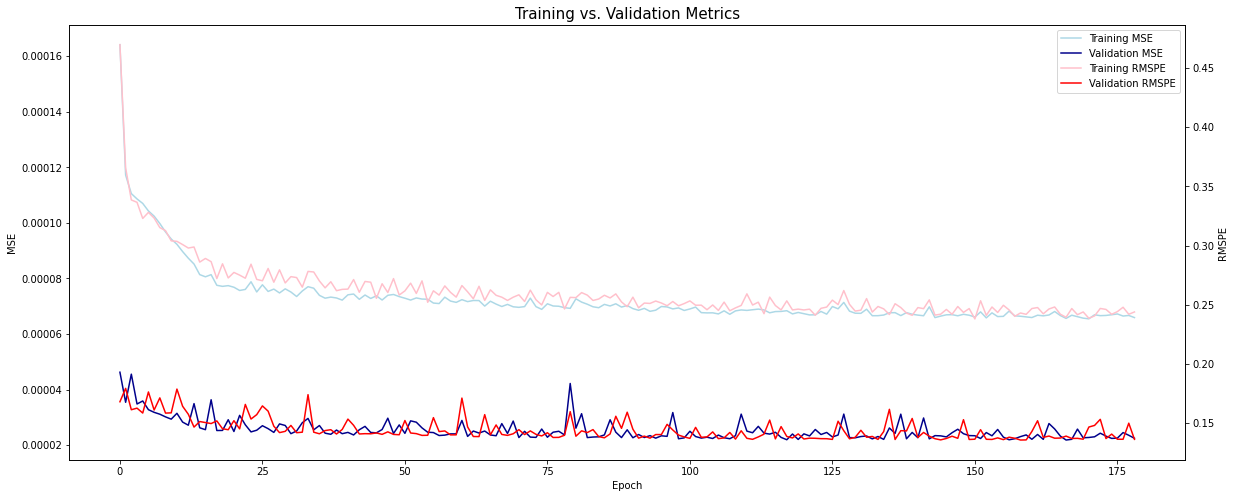

In [265]:
viz_train_val_metrics(lstm_1_res)

Although both lines look pretty unstable, overall there's a downward trend.

#### Forecasting on the Validation set

In [266]:
lstm_1_preds_scaled = val_forecast(lstm_1)

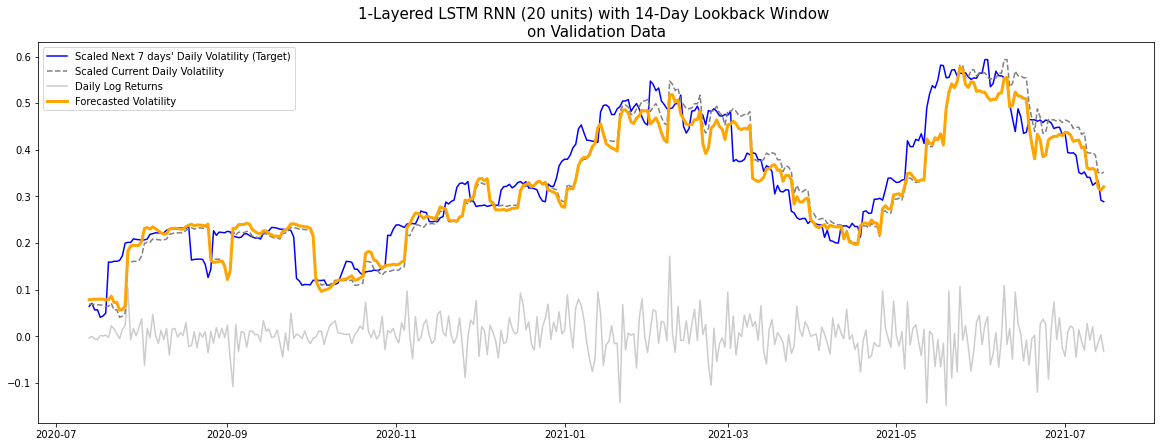

In [267]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_1_preds_scaled, 
          f"1-Layered LSTM RNN (20 units) with {n_past}-Day Lookback Window")

In [268]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_1_preds_scaled, 
         f"LSTM 1 layer 20 units | n_past={n_past}")

Model  ...  Validation RMSE
0                                             Mean Baseline  ...         0.136594
1                                               Random Walk  ...         0.052517
2                  GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185294
3    Analytic GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091115
4         Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.104548
5  Simulation GJR-GARCH(1,1,1) | Constant Mean | skewt dist  ...         0.091578
6   Bootstrap GJR-GARCH(1,1,1) | Constant Mean | skewt Dist  ...         0.083858
7                  Simple LR Fully Connected NN | n_past=14  ...         0.054558
8                         LSTM 1 layer 20 units | n_past=14  ...         0.050376

[9 rows x 3 columns]

The performance of the 1 layered LSTM networks with 20 is getting close to the Random Walk model (which is still the best one so far in terms of RMSPE unfortunately). 

(Source: https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/#:~:text=Bidirectional%20LSTMs%20are%20an%20extension,LSTMs%20on%20the%20input%20sequence)

Further research shows that there's an extension of LSTM cell called **Bidirectional LSTM**, which could potentially be better in this case by providing additional context to the models. "In problems where all timesteps of the input sequence are available, Bidirectional LSTMs train two instead of one LSTMs on the input sequence. The first on the input sequence as-is and the second on a reversed copy of the input sequence. This can provide additional context to the network and result in faster and even fuller learning on the problem." 

I'll also increase the number of hidden layers to see if the model can capture certain patterns better.

In [269]:
tf.keras.backend.clear_session()

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

lstm_2 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_2.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_2.h5',
                                save_best_only=True,
                                monitor='loss')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_2_res = lstm_2.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/200
33/33 [==============================] - 9s 85ms/step - loss: 3.3676e-04 - rmspe: 0.6873 - val_loss: 8.2641e-05 - val_rmspe: 0.1928
Epoch 2/200
33/33 [==============================] - 1s 25ms/step - loss: 1.3531e-04 - rmspe: 0.3966 - val_loss: 3.9354e-05 - val_rmspe: 0.1821
Epoch 3/200
33/33 [==============================] - 1s 27ms/step - loss: 1.2240e-04 - rmspe: 0.3565 - val_loss: 3.8754e-05 - val_rmspe: 0.1687
Epoch 4/200
33/33 [==============================] - 1s 25ms/step - loss: 1.1663e-04 - rmspe: 0.3461 - val_loss: 3.7042e-05 - val_rmspe: 0.1733
Epoch 5/200
33/33 [==============================] - 1s 25ms/step - loss: 1.0554e-04 - rmspe: 0.3395 - val_loss: 3.2156e-05 - val_rmspe: 0.1766
Epoch 6/200
33/33 [==============================] - 1s 25ms/step - loss: 9.6758e-05 - rmspe: 0.3178 - val_loss: 3.0765e-05 - val_rmspe: 0.1511
Epoch 7/200
33/33 [==============================] - 1s 24ms/step - loss: 8.6724e-05 - rmspe: 0.2985 - val_loss: 3.3443e-05 - val_rmspe:

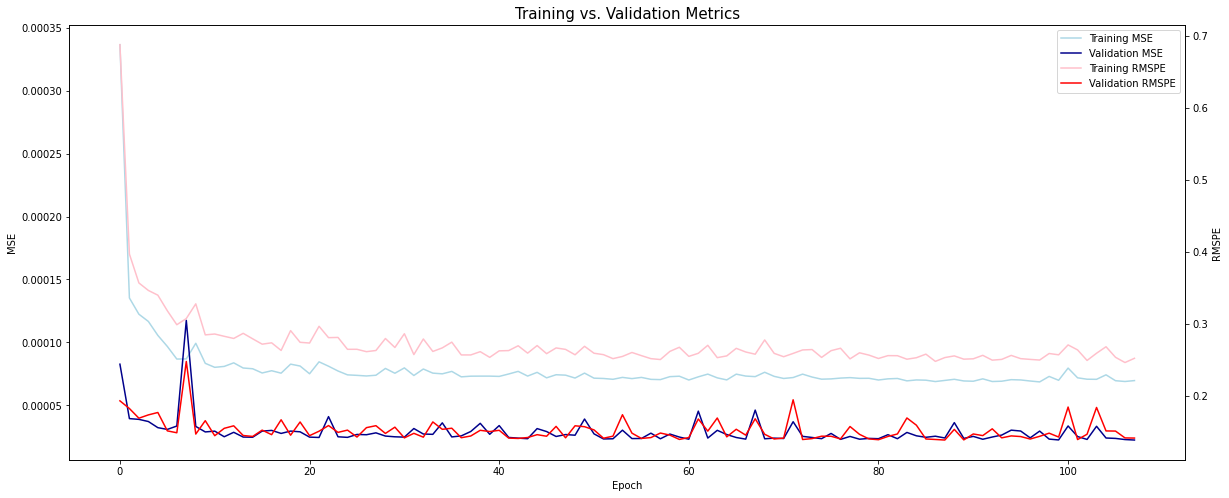

In [270]:
viz_train_val_metrics(lstm_2_res)

In [271]:
# MAKE PREDICTIONS ON VALIDATION SET
lstm_2_preds_scaled = model_forecast_val(lstm_2)

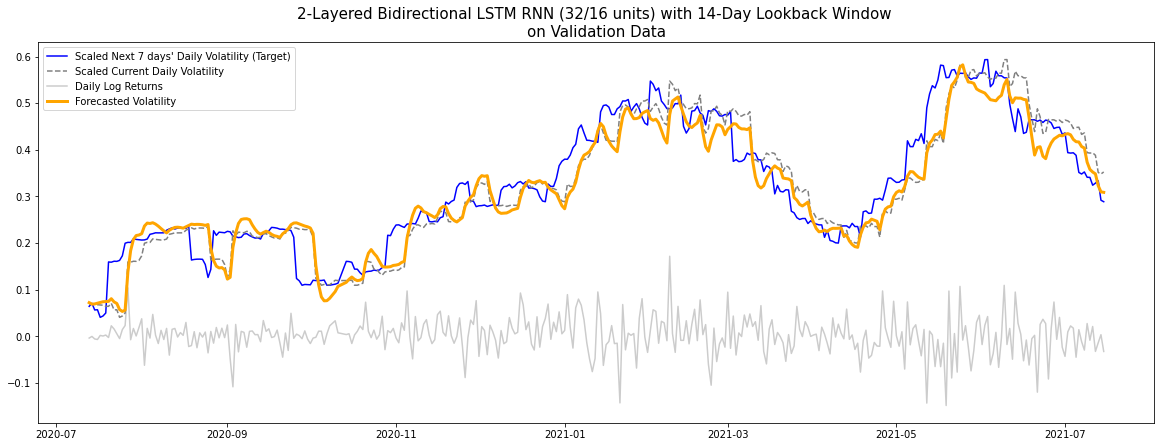

In [272]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_2_preds_scaled, 
          f"2-Layered Bidirectional LSTM RNN (32/16 units) with {n_past}-Day Lookback Window")

In [273]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_2_preds_scaled, 
         f"2 layers Bidirect LSTM (32/16 units) | n_past={n_past}")

Model  ...  Validation RMSE
0                                             Mean Baseline  ...         0.136594
1                                               Random Walk  ...         0.052517
2                  GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185294
3    Analytic GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091115
4         Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.104548
5  Simulation GJR-GARCH(1,1,1) | Constant Mean | skewt dist  ...         0.091578
6   Bootstrap GJR-GARCH(1,1,1) | Constant Mean | skewt Dist  ...         0.083858
7                  Simple LR Fully Connected NN | n_past=14  ...         0.054558
8                         LSTM 1 layer 20 units | n_past=14  ...         0.050376
9          2 layers Bidirect LSTM (32/16 units) | n_past=14  ...         0.051174

[10 rows x 3 columns]

#### Increasing Lookback Window & Number of Hidden LSTM Layers

I also want to experiment with other activation functions because the target input cannot be negative --> need to look more into that.


In [275]:
tf.keras.backend.clear_session()

# INCREASING LOOK BACK WINDOW TO 1 month
n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

lstm_3 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu',
                                                       return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_3.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_3.h5',
                                save_best_only=True,
                                monitor='loss')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_3_res = lstm_3.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/200
33/33 [==============================] - 7s 66ms/step - loss: 3.3951e-04 - rmspe: 0.6979 - val_loss: 1.3059e-04 - val_rmspe: 0.2252
Epoch 2/200
33/33 [==============================] - 2s 46ms/step - loss: 1.8826e-04 - rmspe: 0.5278 - val_loss: 5.9036e-05 - val_rmspe: 0.2013
Epoch 3/200
33/33 [==============================] - 2s 51ms/step - loss: 1.4808e-04 - rmspe: 0.4285 - val_loss: 5.3563e-05 - val_rmspe: 0.1769
Epoch 4/200
33/33 [==============================] - 2s 51ms/step - loss: 1.3459e-04 - rmspe: 0.3878 - val_loss: 4.2726e-05 - val_rmspe: 0.1729
Epoch 5/200
33/33 [==============================] - 2s 50ms/step - loss: 1.2475e-04 - rmspe: 0.3682 - val_loss: 3.6895e-05 - val_rmspe: 0.1748
Epoch 6/200
33/33 [==============================] - 2s 48ms/step - loss: 1.1622e-04 - rmspe: 0.3752 - val_loss: 4.9072e-05 - val_rmspe: 0.1544
Epoch 7/200
33/33 [==============================] - 2s 46ms/step - loss: 1.0709e-04 - rmspe: 0.3452 - val_loss: 3.1274e-05 - val_rmspe:

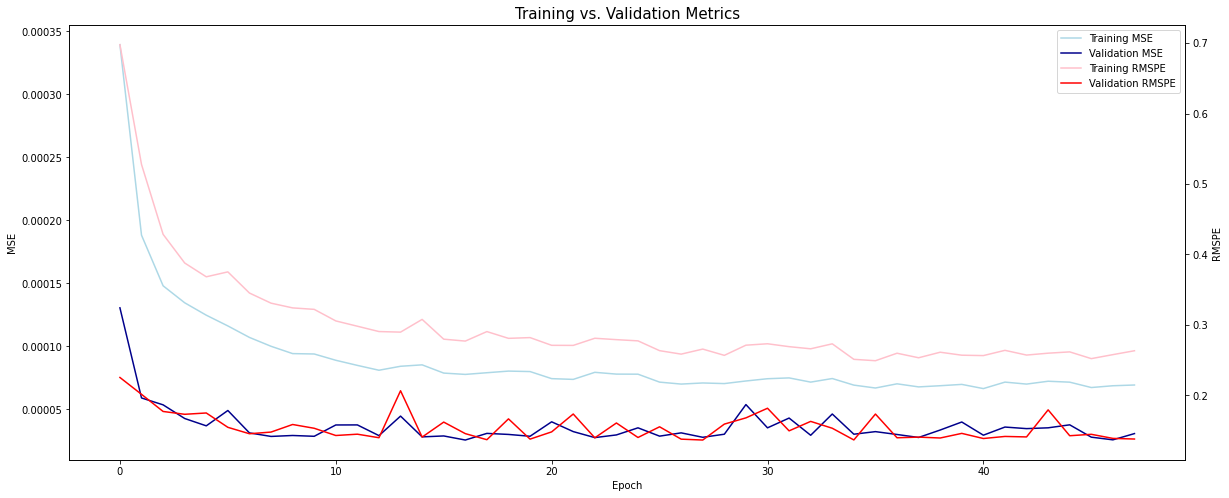

In [276]:
viz_train_val_metrics(lstm_3_res)

In [277]:
# MAKE PREDICTIONS ON VALIDATION SET
lstm_3_preds_scaled = model_forecast_val(lstm_3)

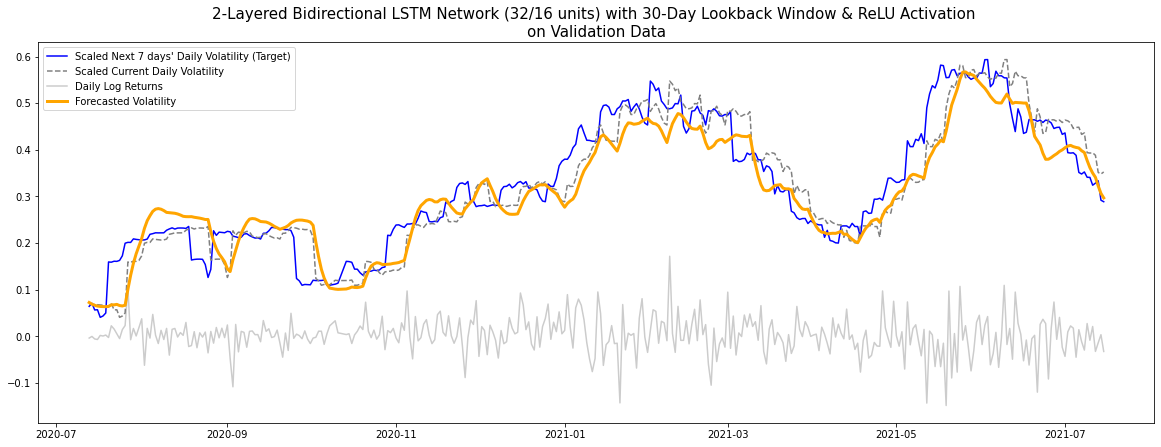

In [278]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_3_preds_scaled, 
          f"2-Layered Bidirectional LSTM Network (32/16 units) with {n_past}-Day Lookback Window & ReLU Activation")

In [279]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_3_preds_scaled, 
         f"Bidirectional LSTM 2 layers 32/16 units | n_past={n_past} | act=relu")

Model  ...  Validation RMSE
0                                                    Mean Baseline  ...         0.136594
1                                                      Random Walk  ...         0.052517
2                         GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185294
3           Analytic GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091115
4                Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.104548
5         Simulation GJR-GARCH(1,1,1) | Constant Mean | skewt dist  ...         0.091578
6          Bootstrap GJR-GARCH(1,1,1) | Constant Mean | skewt Dist  ...         0.083858
7                         Simple LR Fully Connected NN | n_past=14  ...         0.054558
8                                LSTM 1 layer 20 units | n_past=14  ...         0.050376
9                 2 layers Bidirect LSTM (32/16 units) | n_past=14  ...         0.051174
10  Bidirectional LSTM 2 layers 32/16 units | n_past=30 | act=relu  ...         0.055499

[11 rows x 3 columns]

Overall the results for this model are a bit better than GARCH models.

I want to keep extending look back window to see where is the furthest I can go without smoothing out the prediction line too much. From further research I found out that 1D Convolultional Layers can also be added to the NN structure to help learn both short-term and long-term patterns more efficiently.

#### Adding Convolutional Layers to LSTM

Source: Hands-on... - A. Geron
A 1D convolutional layer slides several kernels across a sequence, producing a 1D feature map per kernel. Each kernel will learn to detect a single very short sequential pattern (no longer than the kernel size). 

Convolutional layers allow me to extend the number of past time steps to be included, and help the model pick up patterns without smoothing out the volatility prediction line.

In [335]:
# Ref: https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/supplement/DM4fi/convolutional-neural-networks-course

# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# INCREASING n_past TO 30 DAYS
n_past = 180
batch_size = 128

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

lstm_4 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),
    # ADDING 1D CONVOLUTIONAL LAYER 
    tf.keras.layers.Conv1D(filters=32, kernel_size=4,
                           # DOWNSAMPLE INPUT SEQUENCE BY A FACTOR OF 2
                           strides=2, padding="valid",    
                           activation="relu",
                           input_shape=[None, 1]),                            
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, activation='relu',
                                                       return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, activation='relu',
                                                       return_sequences=True)),
    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_4.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_4.h5',
                                save_best_only=True,
                                monitor='loss')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_4_res = lstm_4.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/200
15/15 [==============================] - 13s 348ms/step - loss: 5.6654e-04 - rmspe: 1.0321 - val_loss: 2.6721e-04 - val_rmspe: 0.3098
Epoch 2/200
15/15 [==============================] - 4s 249ms/step - loss: 3.3492e-04 - rmspe: 0.7320 - val_loss: 1.7843e-04 - val_rmspe: 0.2612
Epoch 3/200
15/15 [==============================] - 4s 251ms/step - loss: 3.1811e-04 - rmspe: 0.8269 - val_loss: 2.5735e-04 - val_rmspe: 0.3036
Epoch 4/200
15/15 [==============================] - 4s 252ms/step - loss: 3.0535e-04 - rmspe: 0.8231 - val_loss: 2.4800e-04 - val_rmspe: 0.2979
Epoch 5/200
15/15 [==============================] - 4s 248ms/step - loss: 2.9237e-04 - rmspe: 0.7547 - val_loss: 2.2761e-04 - val_rmspe: 0.2849
Epoch 6/200
15/15 [==============================] - 4s 244ms/step - loss: 2.5527e-04 - rmspe: 0.7182 - val_loss: 1.6427e-04 - val_rmspe: 0.2431
Epoch 7/200
15/15 [==============================] - 4s 248ms/step - loss: 2.0521e-04 - rmspe: 0.5824 - val_loss: 1.2778e-04 - va

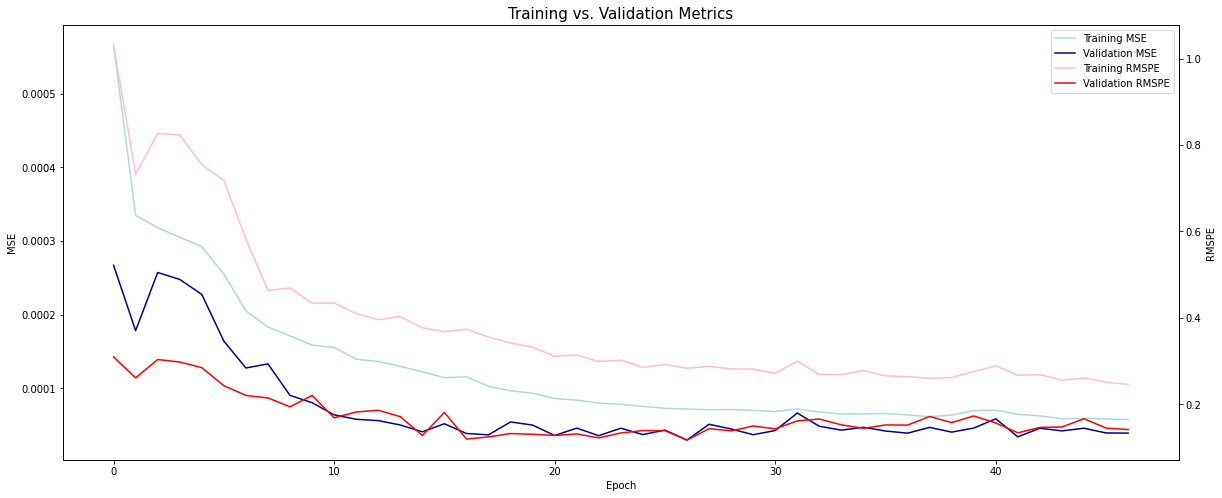

In [336]:
viz_train_val_metrics(lstm_4_res)

In [337]:
# MAKE PREDICTIONS ON VALIDATION SET
lstm_4_preds_scaled = model_forecast_val(lstm_4)

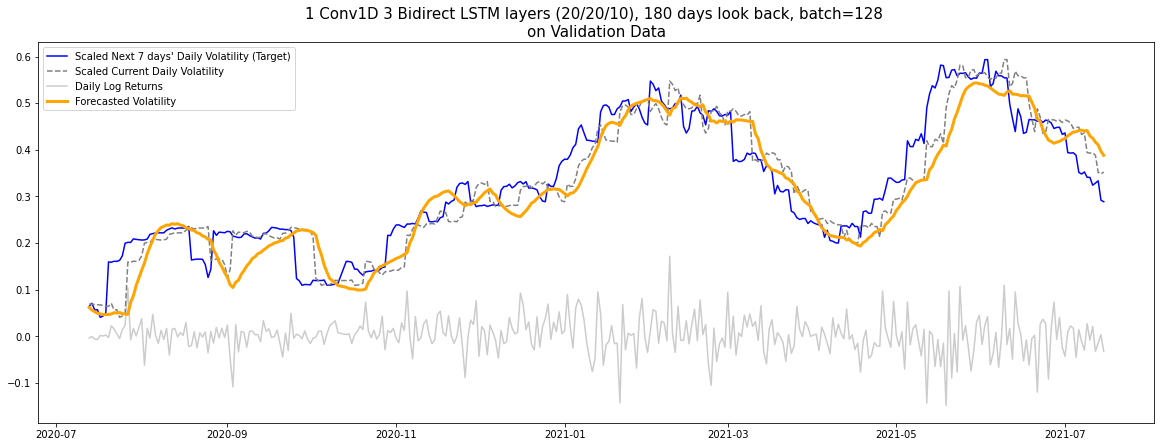

In [338]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_4_preds_scaled, 
          f"1 Conv1D 3 Bidirect LSTM layers (20/20/10), {n_past} days look back, batch={batch_size}")

In [339]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_4_preds_scaled, 
         f"1 Conv1D 3 Bidirect LSTM layers (20/20/10) | n_past={n_past} | batch={batch_size}")

Model  ...  Validation RMSE
0                                                         Mean Baseline  ...         0.136594
1                                                           Random Walk  ...         0.052517
2                              GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185294
3                Analytic GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091115
4                     Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.104548
5              Simulation GJR-GARCH(1,1,1) | Constant Mean | skewt dist  ...         0.091578
6               Bootstrap GJR-GARCH(1,1,1) | Constant Mean | skewt Dist  ...         0.083858
7                              Simple LR Fully Connected NN | n_past=14  ...         0.054558
8                                     LSTM 1 layer 20 units | n_past=14  ...         0.050376
9                      2 layers Bidirect LSTM (32/16 units) | n_past=14  ...         0.051174
10       Bidirectional LSTM 2 layers 32/16 units | n_past=30 | act=relu  ...         0.055499
11   1 Conv1D 3 Bidirect LSTM layers (20/20/10) | n_past=60 | batch=128  ...         0.057586
12   1 Conv1D 3 Bidirect LSTM layers (20/20/10) | n_past=14 | batch=128  ...         0.058663
13  1 Conv1D 3 Bidirect LSTM layers (20/20/10) | n_past=180 | batch=128  ...         0.060390

[14 rows x 3 columns]

### Learning Rate Tuning

In [342]:
# Ref: https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/supplement/DM4fi/convolutional-neural-networks-course

# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

n_past = 14
batch_size = 128

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

lstm_5 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),
    # ADDING 1D CONVOLUTIONAL LAYER 
    tf.keras.layers.Conv1D(filters=32, kernel_size=4,
                           # DOWNSAMPLE INPUT SEQUENCE BY A FACTOR OF 2
                           strides=2, padding="valid",    
                           activation="relu",
                           input_shape=[None, 1]),                            
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu',
                                                       return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
lstm_5.compile(loss='mse',
               optimizer=optimizer,
               metrics=[rmspe])

lstm_5_res = lstm_5.fit(mat_X_train, mat_y_train, epochs=160,
                        callbacks=[lr_schedule],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/160
17/17 [==============================] - 6s 61ms/step - loss: 0.0016 - rmspe: 0.9927 - val_loss: 0.0017 - val_rmspe: 0.9932
Epoch 2/160
17/17 [==============================] - 0s 18ms/step - loss: 0.0016 - rmspe: 0.9927 - val_loss: 0.0017 - val_rmspe: 0.9932
Epoch 3/160
17/17 [==============================] - 0s 20ms/step - loss: 0.0016 - rmspe: 0.9926 - val_loss: 0.0017 - val_rmspe: 0.9932
Epoch 4/160
17/17 [==============================] - 0s 18ms/step - loss: 0.0016 - rmspe: 0.9926 - val_loss: 0.0017 - val_rmspe: 0.9932
Epoch 5/160
17/17 [==============================] - 0s 19ms/step - loss: 0.0016 - rmspe: 0.9926 - val_loss: 0.0017 - val_rmspe: 0.9932
Epoch 6/160
17/17 [==============================] - 0s 20ms/step - loss: 0.0016 - rmspe: 0.9926 - val_loss: 0.0017 - val_rmspe: 0.9932
Epoch 7/160
17/17 [==============================] - 0s 18ms/step - loss: 0.0016 - rmspe: 0.9926 - val_loss: 0.0017 - val_rmspe: 0.9932
Epoch 8/160
17/17 [=============================

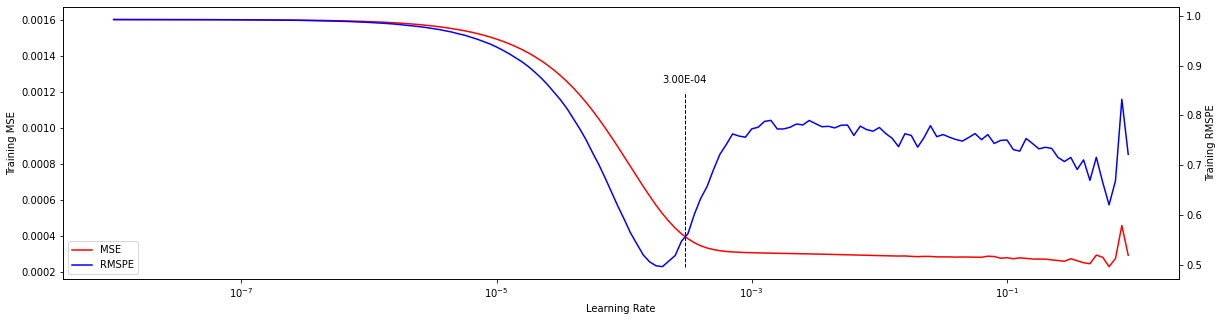

In [353]:
fig, ax = plt.subplots(figsize=(20,5))

# PLOT MSE - LEFT Y-AXIS
ln1 = ax.semilogx(lstm_5_res.history['lr'], lstm_5_res.history['loss'], 
            color='red', label='MSE')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Training MSE')

# PLOT RMSE - RIGHT Y-AXIS
ax2 = ax.twinx()
ln2 = ax2.semilogx(lstm_5_res.history['lr'], lstm_5_res.history['rmspe'],
             color='blue', label='RMSPE')
ax2.set_ylabel('Training RMSPE')

# COMBINING LALBELS FOR 2 LINES INTO 1 LEGEND
lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='lower left')

best_lr = 3e-4

ax.vlines(x=best_lr, ls='--', lw=1,
           ymin=np.min(lstm_5_res.history["loss"]),
           ymax=0.0012)

ax.text(2e-4, 0.00125, '%.2E' % Decimal(best_lr))

plt.show();

In [354]:
# Ref: https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/supplement/DM4fi/convolutional-neural-networks-course

# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

n_past = 14
batch_size = 128

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

lstm_5 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),
    # ADDING 1D CONVOLUTIONAL LAYER 
    tf.keras.layers.Conv1D(filters=32, kernel_size=4,
                           # DOWNSAMPLE INPUT SEQUENCE BY A FACTOR OF 2
                           strides=2, padding="valid",    
                           activation="relu",
                           input_shape=[None, 1]),                            
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='relu',
                                                       return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=best_lr, momentum=0.9)
lstm_5.compile(loss='mse',
               optimizer=optimizer,
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_5.h5',
                                save_best_only=True,
                                monitor='loss')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_5_res = lstm_5.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/200
17/17 [==============================] - 6s 62ms/step - loss: 0.0014 - rmspe: 0.8970 - val_loss: 0.0013 - val_rmspe: 0.8517
Epoch 2/200
17/17 [==============================] - 0s 20ms/step - loss: 0.0011 - rmspe: 0.7425 - val_loss: 9.5288e-04 - val_rmspe: 0.7059
Epoch 3/200
17/17 [==============================] - 0s 20ms/step - loss: 8.3381e-04 - rmspe: 0.5935 - val_loss: 6.9378e-04 - val_rmspe: 0.5737
Epoch 4/200
17/17 [==============================] - 0s 19ms/step - loss: 6.4268e-04 - rmspe: 0.5105 - val_loss: 5.1575e-04 - val_rmspe: 0.4697
Epoch 5/200
17/17 [==============================] - 0s 21ms/step - loss: 5.1524e-04 - rmspe: 0.4753 - val_loss: 3.9698e-04 - val_rmspe: 0.3962
Epoch 6/200
17/17 [==============================] - 0s 19ms/step - loss: 4.3505e-04 - rmspe: 0.4920 - val_loss: 3.1772e-04 - val_rmspe: 0.3517
Epoch 7/200
17/17 [==============================] - 0s 19ms/step - loss: 3.8371e-04 - rmspe: 0.5175 - val_loss: 2.6533e-04 - val_rmspe: 0.3292
Epoc

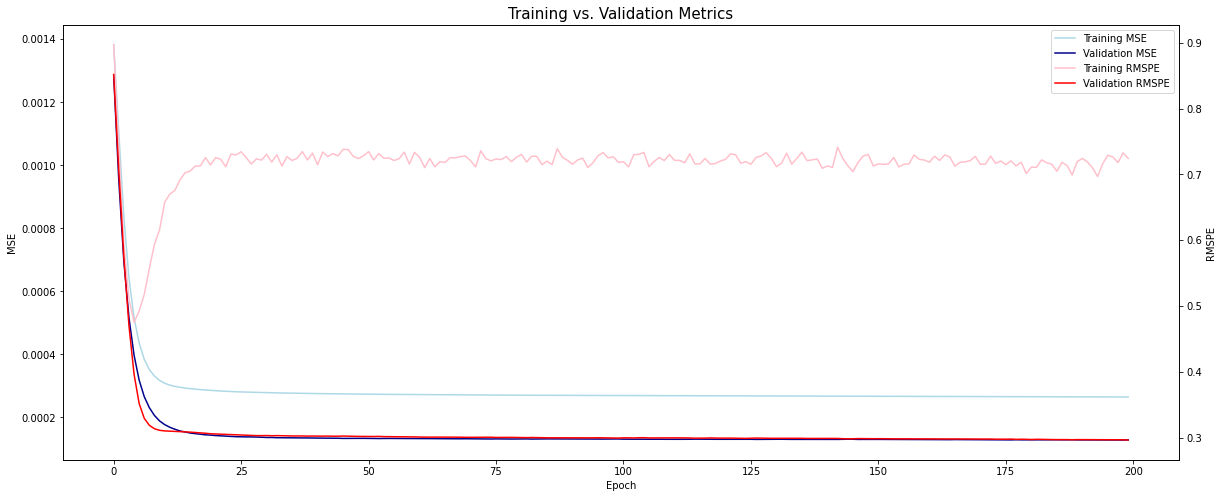

In [355]:
viz_train_val_metrics(lstm_5_res)

In [356]:
# MAKE PREDICTIONS ON VALIDATION SET
lstm_5_preds_scaled = model_forecast_val(lstm_5)

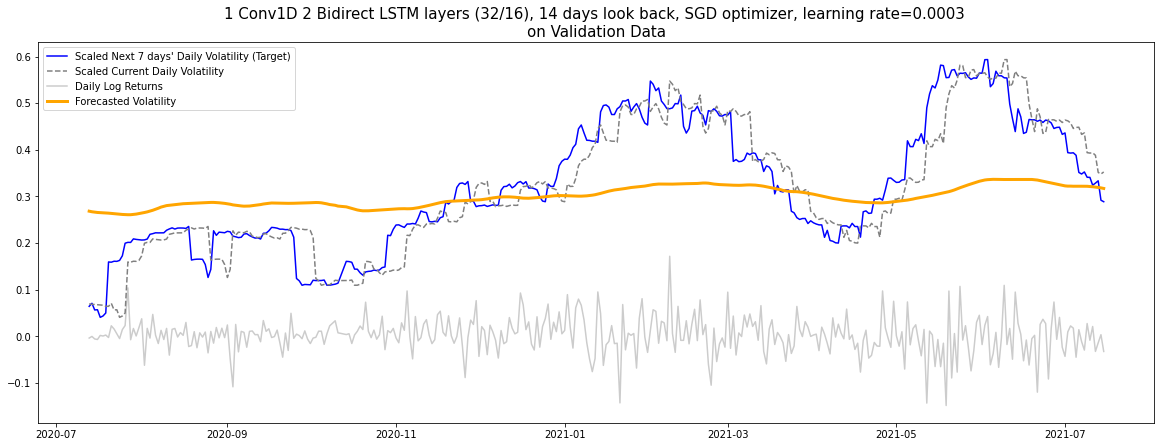

In [357]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_5_preds_scaled, 
          f"1 Conv1D 2 Bidirect LSTM layers (32/16), {n_past} days look back, SGD optimizer, learning rate={best_lr}")

In [358]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_5_preds_scaled, 
         f"1 Conv1D 2 Bidirect LSTM layers (32/16) | n_past={n_past} | batch={batch_size} | SGD lr={best_lr}")

Model  ...  Validation RMSE
0                                                                     Mean Baseline  ...         0.136594
1                                                                       Random Walk  ...         0.052517
2                                          GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185294
3                            Analytic GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091115
4                                 Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.104548
5                          Simulation GJR-GARCH(1,1,1) | Constant Mean | skewt dist  ...         0.091578
6                           Bootstrap GJR-GARCH(1,1,1) | Constant Mean | skewt Dist  ...         0.083858
7                                          Simple LR Fully Connected NN | n_past=14  ...         0.054558
8                                                 LSTM 1 layer 20 units | n_past=14  ...         0.050376
9                                  2 layers Bidirect LSTM (32/16 units) | n_past=14  ...         0.051174
10                   Bidirectional LSTM 2 layers 32/16 units | n_past=30 | act=relu  ...         0.055499
11               1 Conv1D 3 Bidirect LSTM layers (20/20/10) | n_past=60 | batch=128  ...         0.057586
12               1 Conv1D 3 Bidirect LSTM layers (20/20/10) | n_past=14 | batch=128  ...         0.058663
13              1 Conv1D 3 Bidirect LSTM layers (20/20/10) | n_past=180 | batch=128  ...         0.060390
14  1 Conv1D 2 Bidirect LSTM layers (32/16) | n_past=14 | batch=128 | SGD lr=0.0003  ...         0.119689

[15 rows x 3 columns]

## WaveNet

Source: Hands-on... - O'Reilly

WaveNet was first introduced by Aaron van den Oord and other DeepMind researchers in 2016. The basic architecture include stacked 1D Convolutional layers, doubling dilation rate (or how spread apart each neuron's inputs are) at every layer --> helps lower layers learn short-term patterns and higher layers learn long-term patterns, which works very well on larger sequences.

#### Simple WaveNet

In [308]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

n_past = 30
batch_size = 128

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(x_val, y_val, n_past)

wavenet_1 = tf.keras.models.Sequential()
wavenet_1.add(tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                                     input_shape=[None])),
wavenet_1.add(tf.keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1,2,4,8)*2:
    wavenet_1.add(tf.keras.layers.Conv1D(filters=20, kernel_size=2, padding='causal',
                                    activation='relu', dilation_rate=rate))
wavenet_1.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1)),

wavenet_1.compile(loss='mse', 
                  optimizer="adam", 
                  metrics=[rmspe])

print(wavenet_1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 20)          60        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 20)          820       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 20)          8

In [309]:
wavenet_1_res = wavenet_1.fit(mat_X_train, mat_y_train, 
                              validation_data=(mat_X_val, mat_y_val),
                              epochs=20, batch_size=batch_size, verbose=1)

Epoch 1/20
17/17 [==============================] - 2s 49ms/step - loss: 5.1971e-04 - rmspe: 0.8459 - val_loss: 2.0952e-04 - val_rmspe: 0.3400
Epoch 2/20
17/17 [==============================] - 1s 32ms/step - loss: 3.2790e-04 - rmspe: 0.8164 - val_loss: 1.8764e-04 - val_rmspe: 0.3340
Epoch 3/20
17/17 [==============================] - 1s 31ms/step - loss: 3.1800e-04 - rmspe: 0.7981 - val_loss: 1.6278e-04 - val_rmspe: 0.3235
Epoch 4/20
17/17 [==============================] - 1s 34ms/step - loss: 2.9559e-04 - rmspe: 0.7361 - val_loss: 1.7061e-04 - val_rmspe: 0.2989
Epoch 5/20
17/17 [==============================] - 1s 30ms/step - loss: 2.7685e-04 - rmspe: 0.6695 - val_loss: 1.5287e-04 - val_rmspe: 0.2831
Epoch 6/20
17/17 [==============================] - 1s 34ms/step - loss: 2.6744e-04 - rmspe: 0.6489 - val_loss: 1.0449e-04 - val_rmspe: 0.3007
Epoch 7/20
17/17 [==============================] - 1s 31ms/step - loss: 2.7043e-04 - rmspe: 0.6573 - val_loss: 1.0618e-04 - val_rmspe: 0.2745

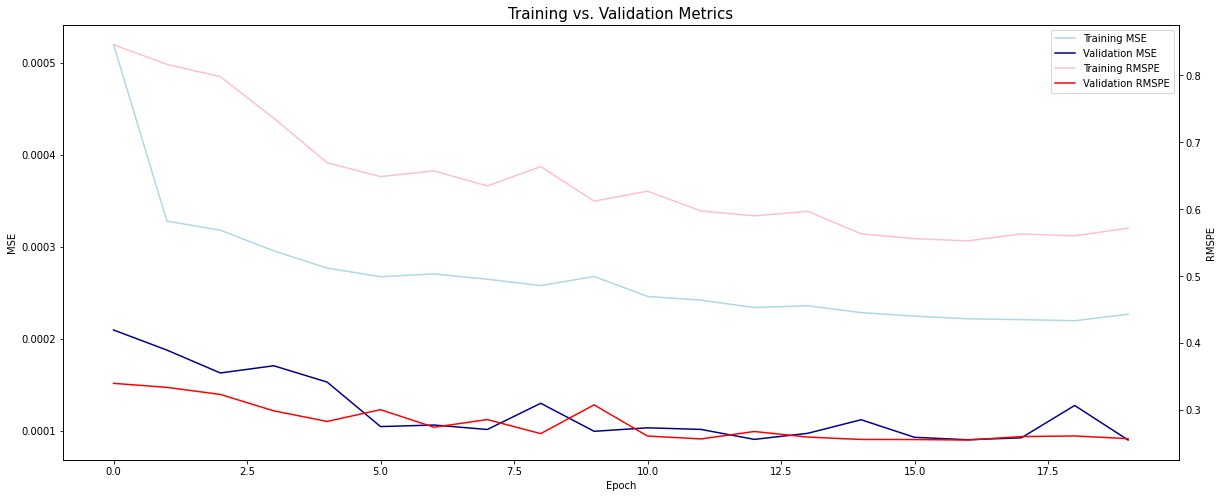

In [310]:
viz_train_val_metrics(wavenet_1_res)

In [327]:
# MAKE PREDICTIONS ON VALIDATION SET
wn_1_preds = wavenet_1.predict(mat_X_val)[:, 0, :]

wn_1_preds_scaled = pd.Series(scaler_vol.transform(wn_1_preds)[:,0],
                              index=val_idx[-len(wn_1_preds):])

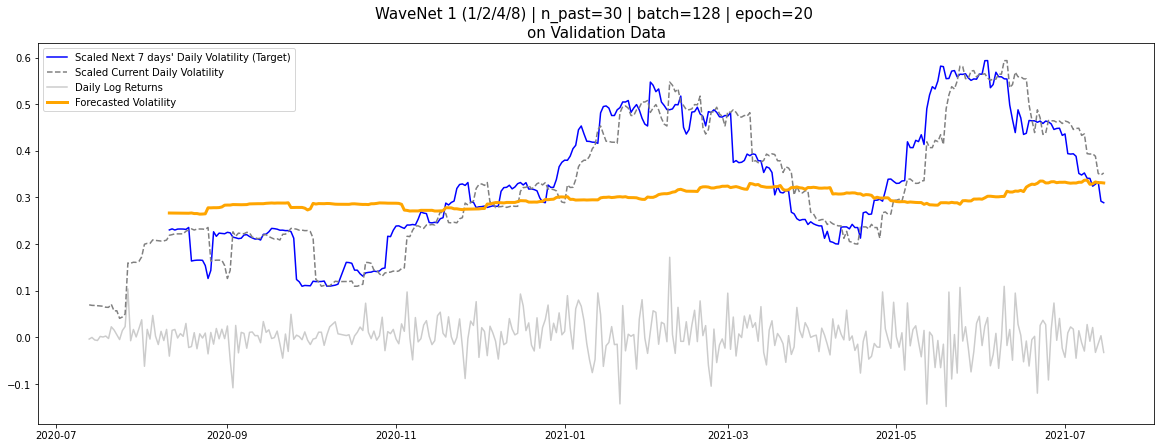

In [329]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled[-len(wn_1_preds_scaled):], wn_1_preds_scaled, 
          f"WaveNet 1 (1/2/4/8) | n_past={n_past} | batch={batch_size} | epoch=20")

In [359]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled[-len(wn_1_preds_scaled):], wn_1_preds_scaled,
         f"Simple WaveNet (1/2/4/8) Conv1D w/dilation | n_past=30 | batch=128")

Model  ...  Validation RMSE
0                                                                     Mean Baseline  ...         0.136594
1                                                                       Random Walk  ...         0.052517
2                                          GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185294
3                            Analytic GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091115
4                                 Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.104548
5                          Simulation GJR-GARCH(1,1,1) | Constant Mean | skewt dist  ...         0.091578
6                           Bootstrap GJR-GARCH(1,1,1) | Constant Mean | skewt Dist  ...         0.083858
7                                          Simple LR Fully Connected NN | n_past=14  ...         0.054558
8                                                 LSTM 1 layer 20 units | n_past=14  ...         0.050376
9                                  2 layers Bidirect LSTM (32/16 units) | n_past=14  ...         0.051174
10                   Bidirectional LSTM 2 layers 32/16 units | n_past=30 | act=relu  ...         0.055499
11               1 Conv1D 3 Bidirect LSTM layers (20/20/10) | n_past=60 | batch=128  ...         0.057586
12               1 Conv1D 3 Bidirect LSTM layers (20/20/10) | n_past=14 | batch=128  ...         0.058663
13              1 Conv1D 3 Bidirect LSTM layers (20/20/10) | n_past=180 | batch=128  ...         0.060390
14  1 Conv1D 2 Bidirect LSTM layers (32/16) | n_past=14 | batch=128 | SGD lr=0.0003  ...         0.119689
15               Simple WaveNet (1/2/4/8) Conv1D w/dilation | n_past=30 | batch=128  ...         0.129192

[16 rows x 3 columns]

### Multivariate LSTM

So far I have only using simple 1-dimensional inputs for all of my models, and for financial data, this is likely insufficient. That could be the reason why none of these models seems to yield better result than Naive Forecasting. It doesn't matter how many neurons or hidden layers are used, or how complex the model's architectures are, inadequate data is not going to produce good results.

For the next section, I'll attempt to create Multivariate Neural Networks to see if additional features could help improve performance.

In [498]:
df.head()

Open        High  ...  vol_current  vol_future
Date                                ...                         
2014-10-17  382.756012  385.477997  ...     0.039872    0.032900
2014-10-18  383.976013  395.157990  ...     0.037566    0.033009
2014-10-19  391.253998  393.938995  ...     0.035089    0.033083
2014-10-20  389.230988  390.084015  ...     0.034629    0.033017
2014-10-21  382.420990  392.645996  ...     0.034362    0.031334

[5 rows x 11 columns]

In [499]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2490 entries, 2014-10-17 to 2021-08-14
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2490 non-null   float64
 1   High          2490 non-null   float64
 2   Low           2490 non-null   float64
 3   Close         2490 non-null   float64
 4   Volume        2490 non-null   int64  
 5   Dividends     2490 non-null   int64  
 6   Stock Splits  2490 non-null   int64  
 7   returns       2490 non-null   float64
 8   log_returns   2490 non-null   float64
 9   vol_current   2490 non-null   float64
 10  vol_future    2490 non-null   float64
dtypes: float64(8), int64(3)
memory usage: 233.4 KB


In [500]:
df.describe()

Open          High  ...  vol_current   vol_future
count   2490.000000   2490.000000  ...  2490.000000  2490.000000
mean    8524.376779   8770.073365  ...     0.036372     0.036375
std    12503.176163  12896.539108  ...     0.017267     0.017267
min      176.897003    211.731003  ...     0.007228     0.007228
25%      581.467987    588.408997  ...     0.024461     0.024461
50%     5246.571289   5356.358154  ...     0.033920     0.033962
75%     9469.311768   9654.489258  ...     0.046106     0.046106
max    63523.753906  64863.097656  ...     0.103878     0.103878

[8 rows x 11 columns]

Since the `Dividends` and `Stock Splits` columns don't really have any useful information (all 0.0), I am going to drop them to downsize the dataframe.

In [501]:
# DROPPING UNUSED COLUMNS
df.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)

In [502]:
df.head()

Open        High  ...  vol_current  vol_future
Date                                ...                         
2014-10-17  382.756012  385.477997  ...     0.039872    0.032900
2014-10-18  383.976013  395.157990  ...     0.037566    0.033009
2014-10-19  391.253998  393.938995  ...     0.035089    0.033083
2014-10-20  389.230988  390.084015  ...     0.034629    0.033017
2014-10-21  382.420990  392.645996  ...     0.034362    0.031334

[5 rows x 9 columns]

#### Feature Engineering

The Open/High/Low/Close prices are usually very similar and highly correlated to each other. Therefore, instead of keeping all of them in the dataset, I would add 2 more features:
- High-Low Spread - which is the difference between the Highest and Lowest prices intraday as a percentage of the Closing price
- Open-Close Spread - which is the difference between the Close and Open prices intraday as a percentage of the Closing price
- Volume column has very large values that are billions/millions of times larger than the other features. Therefore I'm going to the get `np.log()` of it, and hopefully transform it into a more normal looking distribution.

and eliminate the three `Close`, `Open`, `High`, `Low` columns.

In [503]:
df['HL_sprd'] = np.log((df.High - df.Low) / df.Close)
df['CO_sprd'] = (df.Close - df.Open) / df.Open
df['Volume'] = np.log(df.Volume)

In [504]:
df.head()

Open        High         Low  ...  vol_future   HL_sprd   CO_sprd
Date                                            ...                                
2014-10-17  382.756012  385.477997  375.389008  ...    0.032900 -3.638567  0.002618
2014-10-18  383.976013  395.157990  378.971008  ...    0.033009 -3.185630  0.019444
2014-10-19  391.253998  393.938995  386.457001  ...    0.033083 -3.952483 -0.004365
2014-10-20  389.230988  390.084015  378.252014  ...    0.033017 -3.476822 -0.016407
2014-10-21  382.420990  392.645996  380.834015  ...    0.031334 -3.487953  0.010601

[5 rows x 11 columns]

In [505]:
df.describe()

Open          High  ...      HL_sprd      CO_sprd
count   2490.000000   2490.000000  ...  2490.000000  2490.000000
mean    8524.376779   8770.073365  ...    -3.386880     0.002612
std    12503.176163  12896.539108  ...     0.819430     0.039046
min      176.897003    211.731003  ...    -5.948820    -0.371869
25%      581.467987    588.408997  ...    -3.953482    -0.012631
50%     5246.571289   5356.358154  ...    -3.334286     0.001949
75%     9469.311768   9654.489258  ...    -2.833735     0.017968
max    63523.753906  64863.097656  ...    -0.482304     0.254702

[8 rows x 11 columns]

When a network is fit on unscaled data that has a range of values (e.g. quantities in the 10s to 100s) it is possible for large inputs to slow down the learning and convergence of the NN and in some cases prevent the it from effectively learning the problem. 

In addition, since LSTM uses sigmoid and tanh activation functions which are highly sensitive to magnitude, I'll normalize the dataset by:
- fitting scaler to training data
- fitting & transforming validation data using fitted scaler 

In [506]:
from sklearn.preprocessing import MinMaxScaler

In [381]:
# IDENTIFY COLUMNS TO BE USED AS INPUT FEATURES
feature_cols = ['HL_sprd', 'CO_sprd', 'Volume', 'vol_current']

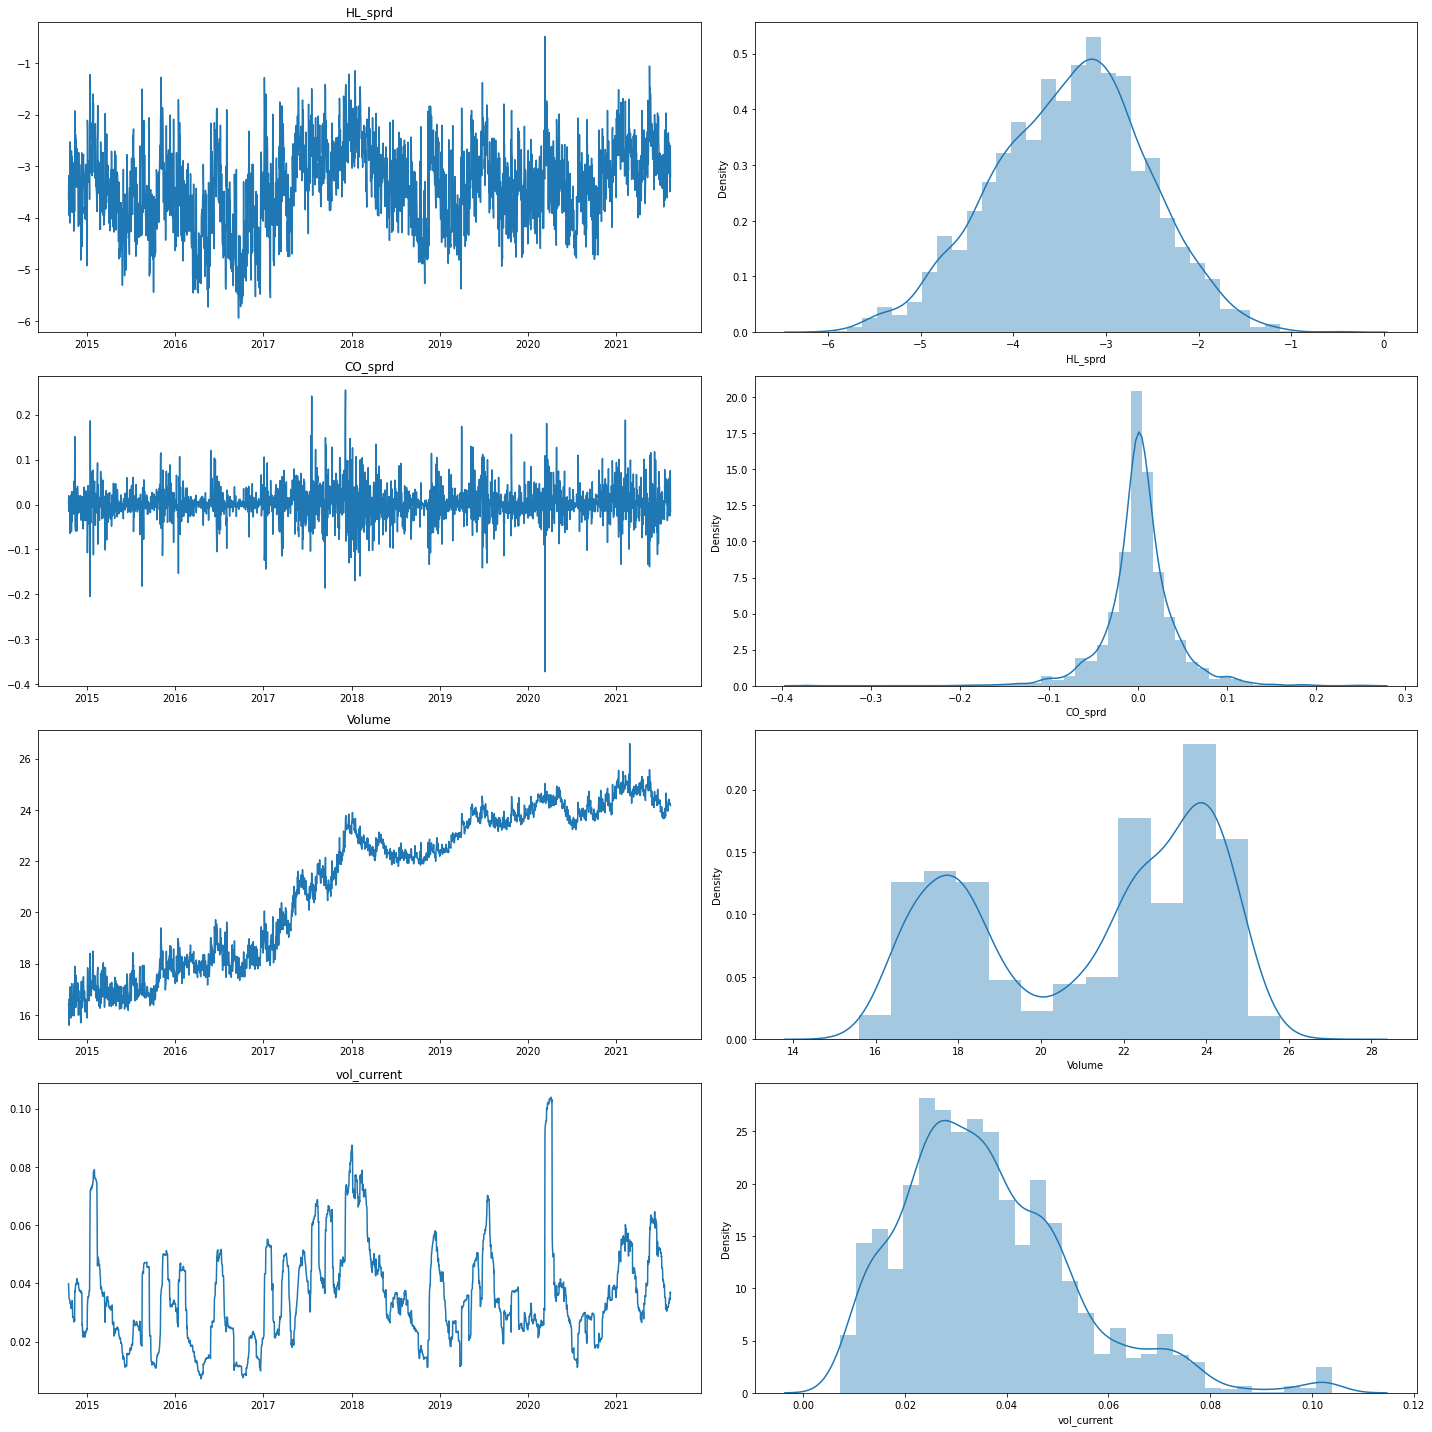

In [509]:
# PLOT EACH COLUMN
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,20))

for i, c in enumerate(feature_cols):
    ax1, ax2 = axes[i][0], axes[i][1]
    ax1.plot(df[c])
    ax1.set_title(c)

    sns.distplot(df[c], ax=ax2)

plt.tight_layout()
plt.show();

In [513]:
cols_to_scale = ['HL_sprd', 'CO_sprd', 'Volume']

# FITTING SCALER TO TRAINING DATA
scaler = MinMaxScaler()
scaler = scaler.fit(df.loc[train_idx][cols_to_scale])

# TRANSFORMING TRAINING DATAFRAME
train_dt_scaled = scaler.transform(df.loc[train_idx][cols_to_scale])
train_df_scaled = pd.DataFrame(train_dt_scaled, 
                               columns=cols_to_scale,
                               index=train_idx) 
train_df_scaled = pd.concat([train_df_scaled, df.vol_current[train_idx]], axis=1)

# TRANSFORMING VALIDATION DATAFRAME
val_dt_scaled = scaler.transform(df.loc[val_idx][cols_to_scale])
val_df_scaled = pd.DataFrame(val_dt_scaled, 
                             columns=cols_to_scale,
                             index=val_idx) 
val_df_scaled = pd.concat([val_df_scaled, df.vol_current[val_idx]], axis=1)

In [545]:
# TRANSFORMING TEST DATAFRAME
test_dt_scaled = scaler.transform(df.loc[test_idx][cols_to_scale])
test_df_scaled = pd.DataFrame(test_dt_scaled, 
                              columns=cols_to_scale,
                              index=test_idx) 
test_df_scaled = pd.concat([test_df_scaled, df.vol_current[test_idx]], axis=1)

In [514]:
train_df_scaled.head()

HL_sprd   CO_sprd    Volume  vol_current
Date                                                 
2014-10-17  0.422619  0.597677  0.088243     0.039872
2014-10-18  0.505475  0.624531  0.069694     0.037566
2014-10-19  0.365194  0.586532  0.000000     0.035089
2014-10-20  0.452207  0.567314  0.108199     0.034629
2014-10-21  0.450171  0.610418  0.092729     0.034362

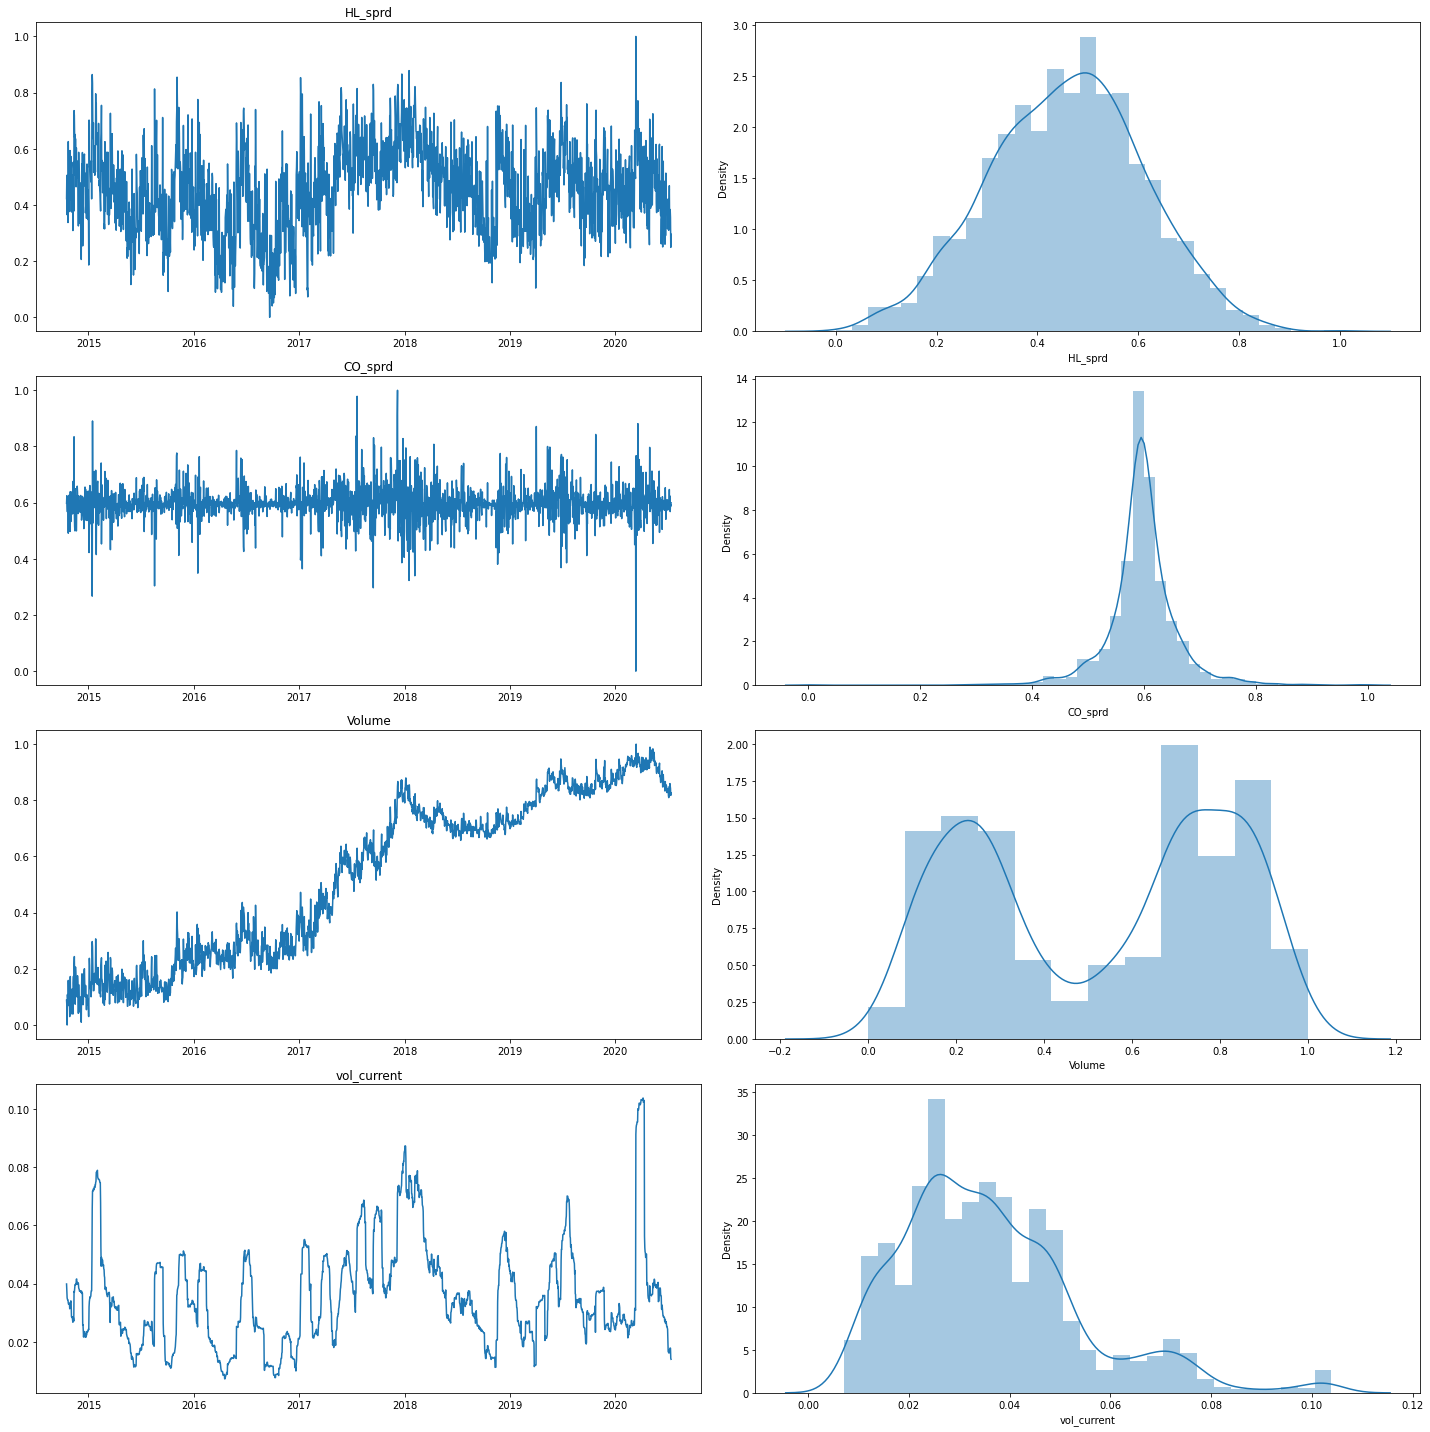

In [515]:
# PLOT EACH COLUMN
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,20))

for i, c in enumerate(feature_cols):
    ax1, ax2 = axes[i][0], axes[i][1]
    ax1.plot(train_df_scaled[c])
    ax1.set_title(c)

    sns.distplot(train_df_scaled[c], ax=ax2)

plt.tight_layout()
plt.show();

The predict here would be to predict next 7 days' volatility (`vol_future`) column using 4 input variables:
1. `HL_sprd`
2. `CO_sprd`
3. `Volume`
5. `vol_current`

Reshaping the inputs is the meat of these Multivariate LSTM. Generally speaking, inputs for LSTM should be in the shape of:

**`[batch_size, n_past, input_dims]`**

in which:

- **`batch_size`** is the number of datapoints in each batch
- **`n_past`** is the number of past time steps to be used for prediction (I'll use the same value as `WINDOW_SIZE` for now.
- **`input_dims`** is the number of input features (which is 6 in this case)  

In [516]:
# Ref: https://www.youtube.com/watch?v=tepxdcepTbY&t=188s

# CONVERT FEATURE DATAFRAME & TARGET SERIES TO MATRICES
def windowed_dataset_multi(x_df, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_df)):
        from_idx = x_df.index[i-lookback_window+1]
        to_idx = x_df.index[i]
        a = x_df[from_idx:to_idx].values
        dataX.append(a)
        dataY.append(y_series[to_idx])

    return np.array(dataX), np.array(dataY)

In [566]:
input_df = pd.concat([train_df_scaled, val_df_scaled, test_df_scaled], axis=0)

In [518]:
tf.keras.backend.clear_session()

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(train_df_scaled, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(val_df_scaled, y_val, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_6 = tf.keras.models.Sequential([
    # tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
    #                        input_shape=[None]),   
    tf.keras.layers.InputLayer(input_shape=[n_past, train_df_scaled.shape[1]]),                         
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_6.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_6.h5',
                                save_best_only=True,
                                monitor='loss')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_6_res = lstm_6.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/200
33/33 [==============================] - 5s 46ms/step - loss: 5.7003e-04 - rmspe: 0.8757 - val_loss: 2.8018e-04 - val_rmspe: 0.5205
Epoch 2/200
33/33 [==============================] - 1s 20ms/step - loss: 2.2944e-04 - rmspe: 0.5347 - val_loss: 1.0113e-04 - val_rmspe: 0.3010
Epoch 3/200
33/33 [==============================] - 1s 22ms/step - loss: 1.6292e-04 - rmspe: 0.4535 - val_loss: 4.6820e-05 - val_rmspe: 0.1880
Epoch 4/200
33/33 [==============================] - 1s 20ms/step - loss: 1.3845e-04 - rmspe: 0.4185 - val_loss: 4.7705e-05 - val_rmspe: 0.1904
Epoch 5/200
33/33 [==============================] - 1s 21ms/step - loss: 1.2185e-04 - rmspe: 0.3859 - val_loss: 3.4000e-05 - val_rmspe: 0.1485
Epoch 6/200
33/33 [==============================] - 1s 21ms/step - loss: 1.1060e-04 - rmspe: 0.3611 - val_loss: 7.9652e-05 - val_rmspe: 0.2518
Epoch 7/200
33/33 [==============================] - 1s 21ms/step - loss: 9.5542e-05 - rmspe: 0.3304 - val_loss: 1.7453e-04 - val_rmspe:

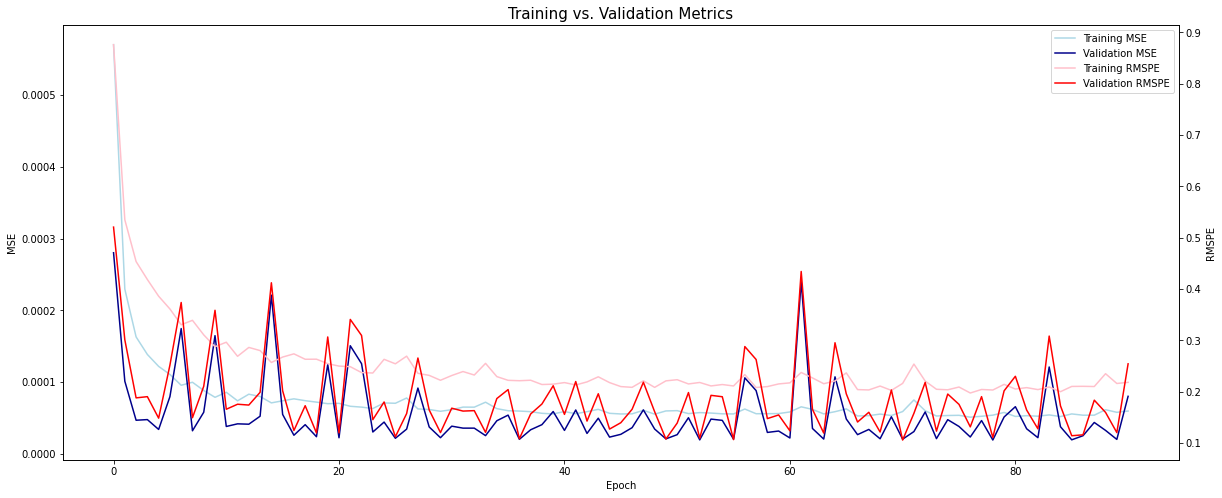

In [519]:
viz_train_val_metrics(lstm_6_res)

In [520]:
def val_forecast2(model):
    forecast = []
    idx = df.index

    # ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
    for i in range(len(val_idx)):
        # GET THE DATA AT THE PREVIOUS n_past TIME STEPS
        # (including current value)
        from_idx = idx[split_time_1 + i - n_past + 1]
        to_idx = idx[split_time_1 + i]
        pred = model.predict(input_df[from_idx:to_idx].values[np.newaxis])
        forecast.append(pred)

    forecast = np.array(forecast)[:, 0, 0]
    preds = pd.Series(forecast, index=val_idx)
    preds_scaled = pd.Series(scaler_vol.transform(preds.values.reshape(-1,1))[:,0],
                                index=val_idx)

    return preds_scaled

In [521]:
# MAKE PREDICTIONS ON VALIDATION SET
lstm_6_preds_scaled = val_forecast2(lstm_6)

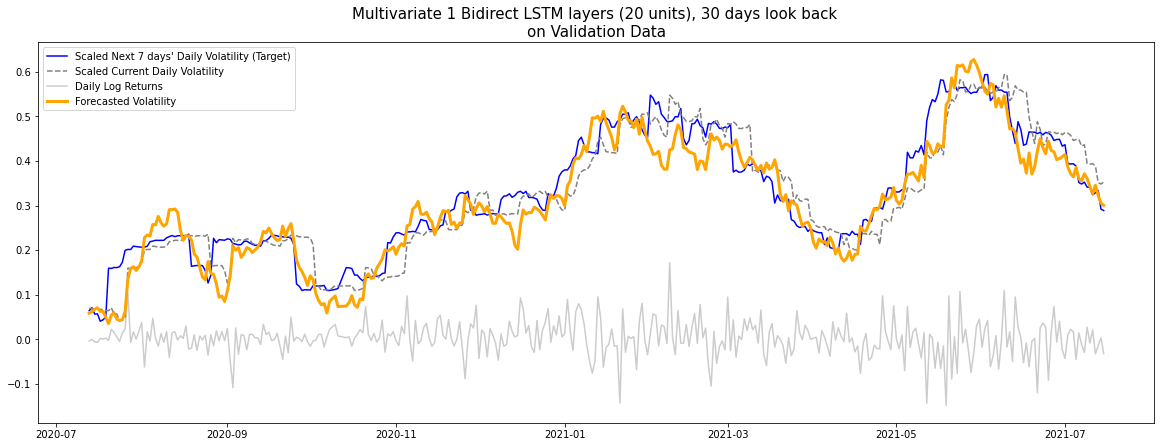

In [523]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_6_preds_scaled, 
          f"Multivariate 1 Bidirect LSTM layers (20 units), {n_past} days look back")

In [525]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_6_preds_scaled,
         f"Multivariate Bidirect LSTM 1 layer (20 units) | n_past={n_past}")

Model  ...  Validation RMSE
0                                                                     Mean Baseline  ...         0.136594
1                                                                       Random Walk  ...         0.052517
2                                          GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185294
3                            Analytic GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091115
4                                 Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.104548
5                          Simulation GJR-GARCH(1,1,1) | Constant Mean | skewt dist  ...         0.091578
6                           Bootstrap GJR-GARCH(1,1,1) | Constant Mean | skewt Dist  ...         0.083858
7                                          Simple LR Fully Connected NN | n_past=14  ...         0.054558
8                                                 LSTM 1 layer 20 units | n_past=14  ...         0.050376
9                                  2 layers Bidirect LSTM (32/16 units) | n_past=14  ...         0.051174
10                   Bidirectional LSTM 2 layers 32/16 units | n_past=30 | act=relu  ...         0.055499
11               1 Conv1D 3 Bidirect LSTM layers (20/20/10) | n_past=60 | batch=128  ...         0.057586
12               1 Conv1D 3 Bidirect LSTM layers (20/20/10) | n_past=14 | batch=128  ...         0.058663
13              1 Conv1D 3 Bidirect LSTM layers (20/20/10) | n_past=180 | batch=128  ...         0.060390
14  1 Conv1D 2 Bidirect LSTM layers (32/16) | n_past=14 | batch=128 | SGD lr=0.0003  ...         0.119689
15               Simple WaveNet (1/2/4/8) Conv1D w/dilation | n_past=30 | batch=128  ...         0.129192
16                        Multivariate Bidirect LSTM 1 layer (20 units) | n_past=30  ...         0.048567

[17 rows x 3 columns]

OMGGGGG!!!! Finally something is less than Naive Forecasting!!!!

<img src="https://bluejaysnation.com/wp-content/uploads/sites/8/2019/09/im-not-crying-youre-crying.jpg " width="200" />

#### Adding Convolutional Layers into Multivariate model

In [555]:
tf.keras.backend.clear_session()

# INCREASING n_past TO 2 MONTHS
n_past = 60
# INCREASING BATCH SIZE TO 128
batch_size = 128

mat_X_train, mat_y_train = windowed_dataset(train_df_scaled, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(val_df_scaled, y_val, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_7 = tf.keras.models.Sequential([
    # ADDING 1D CONVOLUTIONAL LAYER 
    tf.keras.layers.Conv1D(filters=32, kernel_size=4,
                           # DOWNSAMPLE INPUT SEQUENCE BY A FACTOR OF 2
                           strides=2, padding="valid",    
                           activation="relu",
                           input_shape=[n_past, train_df_scaled.shape[1]]),                            
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),

    tf.keras.layers.Dropout(0.15),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_7.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_7.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_7_res = lstm_7.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/200
16/16 [==============================] - 10s 190ms/step - loss: 0.0024 - rmspe: 1.8536 - val_loss: 1.7910e-04 - val_rmspe: 0.4115
Epoch 2/200
16/16 [==============================] - 1s 79ms/step - loss: 6.1778e-04 - rmspe: 0.9259 - val_loss: 1.5697e-04 - val_rmspe: 0.2976
Epoch 3/200
16/16 [==============================] - 1s 80ms/step - loss: 3.4289e-04 - rmspe: 0.7159 - val_loss: 1.3526e-04 - val_rmspe: 0.3266
Epoch 4/200
16/16 [==============================] - 1s 78ms/step - loss: 2.1353e-04 - rmspe: 0.4976 - val_loss: 4.6817e-05 - val_rmspe: 0.1761
Epoch 5/200
16/16 [==============================] - 1s 76ms/step - loss: 1.7103e-04 - rmspe: 0.4563 - val_loss: 6.0209e-05 - val_rmspe: 0.2051
Epoch 6/200
16/16 [==============================] - 1s 81ms/step - loss: 1.3788e-04 - rmspe: 0.3835 - val_loss: 6.5110e-05 - val_rmspe: 0.2112
Epoch 7/200
16/16 [==============================] - 1s 75ms/step - loss: 1.3112e-04 - rmspe: 0.3847 - val_loss: 9.7263e-05 - val_rmspe: 0

In [556]:
# MAKE PREDICTIONS ON VALIDATION SET
lstm_7_preds_scaled = val_forecast2(lstm_7)

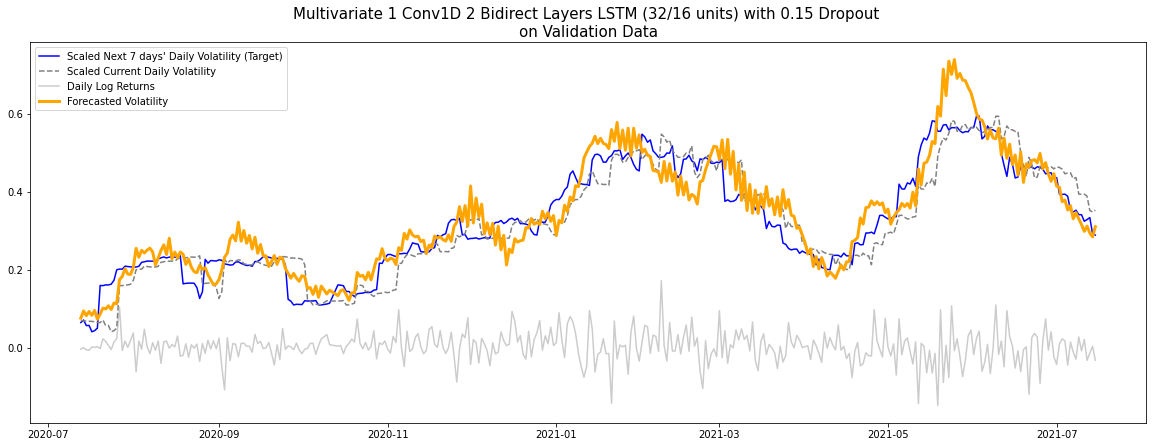

In [557]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_7_preds_scaled, 
          "Multivariate 1 Conv1D 2 Bidirect Layers LSTM (32/16 units) with 0.15 Dropout")

In [558]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_7_preds_scaled, 
         f"Multivariate 1 Conv1D 2 Bidirect Layers LSTM (32/16 units) | dropout=0.15 | n_past={n_past}")

Model  ...  Validation RMSE
0                                                                           Mean Baseline  ...         0.136594
1                                                                             Random Walk  ...         0.052517
2                                                GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185294
3                                  Analytic GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091115
4                                       Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.104548
5                                Simulation GJR-GARCH(1,1,1) | Constant Mean | skewt dist  ...         0.091578
6                                 Bootstrap GJR-GARCH(1,1,1) | Constant Mean | skewt Dist  ...         0.083858
7                                                Simple LR Fully Connected NN | n_past=14  ...         0.054558
8                                                       LSTM 1 layer 20 units | n_past=14  ...         0.050376
9                                        2 layers Bidirect LSTM (32/16 units) | n_past=14  ...         0.051174
10                         Bidirectional LSTM 2 layers 32/16 units | n_past=30 | act=relu  ...         0.055499
11                     1 Conv1D 3 Bidirect LSTM layers (20/20/10) | n_past=60 | batch=128  ...         0.057586
12                     1 Conv1D 3 Bidirect LSTM layers (20/20/10) | n_past=14 | batch=128  ...         0.058663
13                    1 Conv1D 3 Bidirect LSTM layers (20/20/10) | n_past=180 | batch=128  ...         0.060390
14        1 Conv1D 2 Bidirect LSTM layers (32/16) | n_past=14 | batch=128 | SGD lr=0.0003  ...         0.119689
15                     Simple WaveNet (1/2/4/8) Conv1D w/dilation | n_past=30 | batch=128  ...         0.129192
16                              Multivariate Bidirect LSTM 1 layer (20 units) | n_past=30  ...         0.048567
17  Multivariate 1 Conv1D 2 Bidirect Layers LSTM (32/16 units) | dropout=0.15 | n_past=60  ...         0.054273
18               Multivariate 2 Bidirect Layers LSTM (20/10 units) | n_past=30 | batch=64  ...         0.048924
19  Multivariate 1 Conv1D 2 Bidirect Layers LSTM (32/16 units) | dropout=0.15 | n_past=60  ...         0.053094

[20 rows x 3 columns]

Next, I'm just going to add another Bidirectional LSTM layer to the model to see if that'd help improve performance any further. So far I haven't got much luck with including Convolutional Layers in my models. I think it's not because it's not good, it's more likely I don't know how to set it up properly yet. 

In [559]:
tf.keras.backend.clear_session()

n_past = 30
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(train_df_scaled, y_train, n_past)
mat_X_val, mat_y_val = windowed_dataset(val_df_scaled, y_val, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_8 = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, train_df_scaled.shape[1]]),

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_8.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_8.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

lstm_8_res = lstm_8.fit(mat_X_train, mat_y_train, epochs=500,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_data=(mat_X_val, mat_y_val),
                        verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/500
33/33 [==============================] - 17s 145ms/step - loss: 4.1439e-04 - rmspe: 0.6642 - val_loss: 5.0897e-05 - val_rmspe: 0.1416
Epoch 2/500
33/33 [==============================] - 2s 73ms/step - loss: 1.2286e-04 - rmspe: 0.3659 - val_loss: 8.5095e-05 - val_rmspe: 0.2683
Epoch 3/500
33/33 [==============================] - 2s 71ms/step - loss: 1.1546e-04 - rmspe: 0.3411 - val_loss: 7.2016e-05 - val_rmspe: 0.2420
Epoch 4/500
33/33 [==============================] - 2s 72ms/step - loss: 1.1618e-04 - rmspe: 0.3459 - val_loss: 2.2362e-04 - val_rmspe: 0.4283
Epoch 5/500
33/33 [==============================] - 2s 70ms/step - loss: 1.1606e-04 - rmspe: 0.3468 - val_loss: 2.6962e-05 - val_rmspe: 0.1309
Epoch 6/500
33/33 [==============================] - 2s 73ms/step - loss: 1.0060e-04 - rmspe: 0.3095 - val_loss: 6.2495e-05 - val_rmspe: 0.2225
Epoch 7/500
33/33 [==============================] - 2s 74ms/step - loss: 9.4863e-05 - rmspe: 0.2983 - val_loss: 1.2959e-04 - val_rmsp

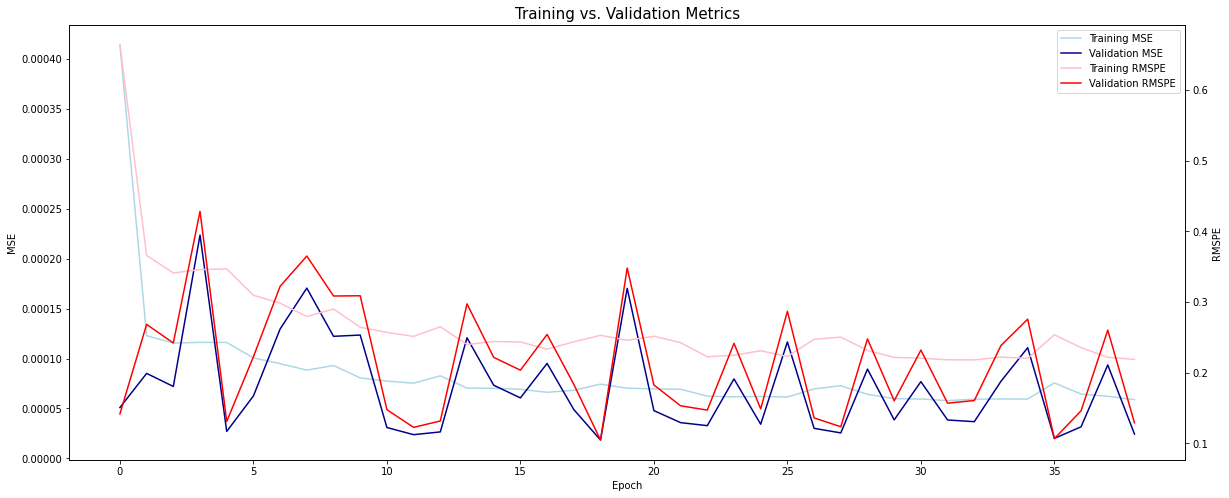

In [560]:
viz_train_val_metrics(lstm_8_res)

In [561]:
# MAKE PREDICTIONS ON VALIDATION SET
lstm_8_preds_scaled = val_forecast2(lstm_8)

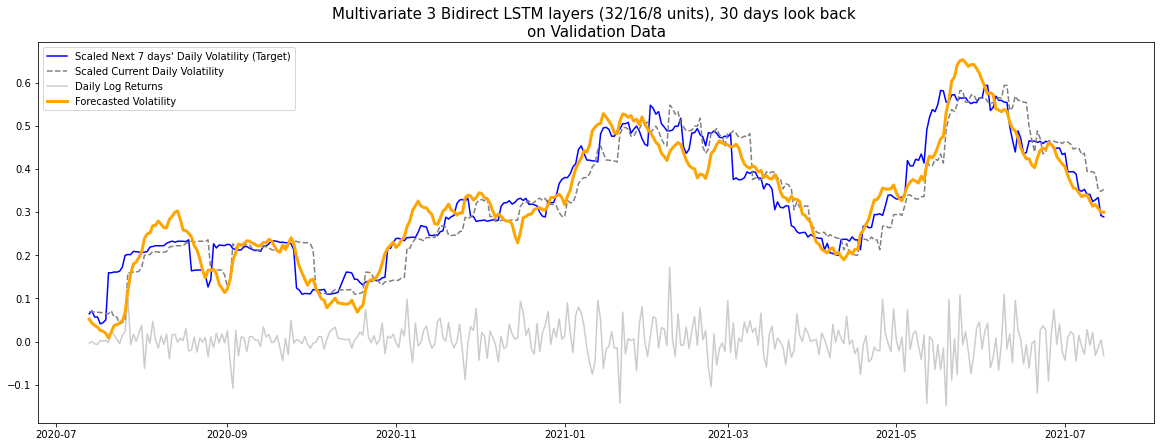

In [563]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_8_preds_scaled, 
          f"Multivariate 3 Bidirect LSTM layers (32/16/8 units), {n_past} days look back")

In [564]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_8_preds_scaled, 
         f"Multivariate 3 Bidirect LSTM layers (32/16/8 units) | n_past={n_past} | batch={batch_size}")

Model  ...  Validation RMSE
0                                                                           Mean Baseline  ...         0.136594
1                                                                             Random Walk  ...         0.052517
2                                                GARCH(1,1) | Constant Mean | Normal Dist  ...         0.185294
3                                  Analytic GJR-GARCH(1,1,1) | Constant Mean | Skewt Dist  ...         0.091115
4                                       Bootstrap TARCH(1,1) | Constant Mean | Skewt Dist  ...         0.104548
5                                Simulation GJR-GARCH(1,1,1) | Constant Mean | skewt dist  ...         0.091578
6                                 Bootstrap GJR-GARCH(1,1,1) | Constant Mean | skewt Dist  ...         0.083858
7                                                Simple LR Fully Connected NN | n_past=14  ...         0.054558
8                                                       LSTM 1 layer 20 units | n_past=14  ...         0.050376
9                                        2 layers Bidirect LSTM (32/16 units) | n_past=14  ...         0.051174
10                         Bidirectional LSTM 2 layers 32/16 units | n_past=30 | act=relu  ...         0.055499
11                     1 Conv1D 3 Bidirect LSTM layers (20/20/10) | n_past=60 | batch=128  ...         0.057586
12                     1 Conv1D 3 Bidirect LSTM layers (20/20/10) | n_past=14 | batch=128  ...         0.058663
13                    1 Conv1D 3 Bidirect LSTM layers (20/20/10) | n_past=180 | batch=128  ...         0.060390
14        1 Conv1D 2 Bidirect LSTM layers (32/16) | n_past=14 | batch=128 | SGD lr=0.0003  ...         0.119689
15                     Simple WaveNet (1/2/4/8) Conv1D w/dilation | n_past=30 | batch=128  ...         0.129192
16                              Multivariate Bidirect LSTM 1 layer (20 units) | n_past=30  ...         0.048567
17  Multivariate 1 Conv1D 2 Bidirect Layers LSTM (32/16 units) | dropout=0.15 | n_past=60  ...         0.054273
18               Multivariate 2 Bidirect Layers LSTM (20/10 units) | n_past=30 | batch=64  ...         0.048924
19  Multivariate 1 Conv1D 2 Bidirect Layers LSTM (32/16 units) | dropout=0.15 | n_past=60  ...         0.053094
20             Multivariate 3 Bidirect LSTM layers (32/16/8 units) | n_past=30 | batch=64  ...         0.047118

[21 rows x 3 columns]

RMSPE decreased by a small margin, while RMSE went up a tiny bit. It seems like so far the best batch size has been 64 for this dataset.

Next, I'm going to combine Training & Validation sets to extend training further, and use that final model to test on the most recent 30 day's numbers (test set).

In [565]:
# COMBINING TRAINING & VALIDATION 
tv_df = pd.concat([train_df_scaled, val_df_scaled], axis=0)
tv_y = pd.concat([y_train, y_val], axis=0)

In [546]:
mat_X_tv, mat_y_tv = windowed_dataset(tv_df, tv_y, n_past)
mat_X_test, mat_y_test = windowed_dataset(test_df_scaled, y_test, n_past)

In [567]:
tf.keras.backend.clear_session()

n_past = 30
batch_size = 64

mat_X_tv, mat_y_tv = windowed_dataset(tv_df, tv_y, n_past)
mat_X_test, mat_y_test = windowed_dataset(test_df_scaled, y_test, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_final = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, train_df_scaled.shape[1]]),                         
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_final.compile(loss='mse', 
                    optimizer="adam", 
                    metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_final.h5',
                                save_best_only=True,
                                monitor='rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=20,
                                  restore_best_weights=True,
                                  monitor='rmspe')

lstm_final_res = lstm_final.fit(mat_X_tv, mat_y_tv, epochs=500,
                                callbacks=[checkpoint_cb, early_stopping_cb],
                                verbose=1, batch_size=batch_size, shuffle=True)

Epoch 1/500
38/38 [==============================] - 8s 41ms/step - loss: 0.0045 - rmspe: 2.3264
Epoch 2/500
38/38 [==============================] - 1s 38ms/step - loss: 3.2553e-04 - rmspe: 0.6609
Epoch 3/500
38/38 [==============================] - 2s 42ms/step - loss: 1.4397e-04 - rmspe: 0.3784
Epoch 4/500
38/38 [==============================] - 2s 41ms/step - loss: 1.0921e-04 - rmspe: 0.3242
Epoch 5/500
38/38 [==============================] - 1s 39ms/step - loss: 1.0224e-04 - rmspe: 0.3155
Epoch 6/500
38/38 [==============================] - 2s 42ms/step - loss: 9.8736e-05 - rmspe: 0.3138
Epoch 7/500
38/38 [==============================] - 2s 42ms/step - loss: 9.6370e-05 - rmspe: 0.3077
Epoch 8/500
38/38 [==============================] - 2s 41ms/step - loss: 9.5280e-05 - rmspe: 0.3037
Epoch 9/500
38/38 [==============================] - 2s 43ms/step - loss: 9.2249e-05 - rmspe: 0.2934
Epoch 10/500
38/38 [==============================] - 1s 40ms/step - loss: 9.0352e-05 - rmspe: 

In [573]:
# MAKING PREDICTIONS ON TEST SET

forecast = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(test_idx)):
    # GET THE DATA AT THE PREVIOUS n_past TIME STEPS
    # (including current value)
    from_idx = idx[split_time_2 + i - n_past + 1]
    to_idx = idx[split_time_2 + i]
    pred = lstm_final.predict(input_df[from_idx:to_idx].values[np.newaxis])
    forecast.append(pred)

forecast = np.array(forecast)[:, 0, 0]
y_test_preds = pd.Series(forecast, index=test_idx)

In [579]:
final_scaler = MinMaxScaler()

# FIT SCALER TO CURRENT REALIZED VOLATILITY IN TRAINING
final_scaler = final_scaler.fit(tv_df.vol_current.values.reshape(-1,1))

# TRANSFORM THE WHOLE DATA'S vol_current & vol_future
vol_current_scaled = pd.Series(final_scaler.transform(df.vol_current.values.reshape(-1,1))[:,0],
                              index=df.index)
vol_future_scaled = pd.Series(final_scaler.transform(df.vol_future.values.reshape(-1,1))[:,0],
                              index=df.index)

# TRANSFORM TEST PREDICTIONS
y_test_preds_scaled = pd.Series(scaler_vol.transform(y_test_preds.values.reshape(-1,1))[:,0],
                         index=test_idx)

In [591]:
q1 = vol_current_scaled[:split_time_2].describe()['25%']

q2 = vol_current_scaled[:split_time_2].describe()['50%']

q3 = vol_current_scaled[:split_time_2].describe()['75%']

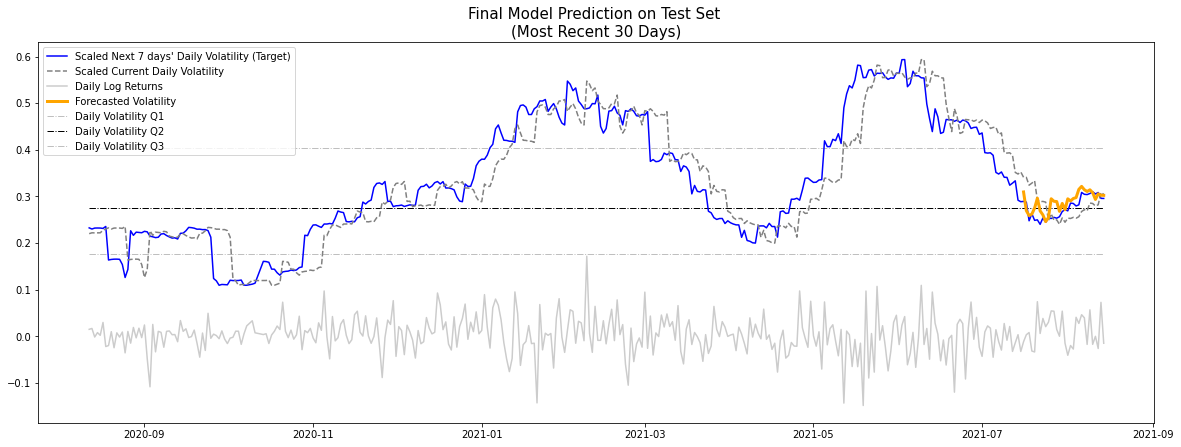

In [600]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
# ZOOMING IN THE LAST n_display VALUES
n_display = 365

plt.figure(figsize=(20,7))
plt.plot(vol_future_scaled[-n_display:], color='blue', 
            label=f"Scaled Next {n_future} days' Daily Volatility (Target)")
plt.plot(vol_current_scaled[-n_display:], color='gray',  ls='--',
            label=f"Scaled Current Daily Volatility")
plt.plot(df.log_returns[-n_display:], color='gray', alpha=0.4,
            label='Daily Log Returns')
plt.plot(y_test_preds_scaled, color='orange', lw=3,
            label=f'Forecasted Volatility')

plt.hlines(y=q1, color='gray', alpha=0.5, label='Daily Volatility Q1', ls='-.', lw=1,
           xmin=vol_future_scaled[-n_display:].index[0],
           xmax=vol_future_scaled[-n_display:].index[-1])

plt.hlines(y=q2, color='black', label='Daily Volatility Q2', ls='-.', lw=1,
           xmin=vol_future_scaled[-n_display:].index[0],
           xmax=vol_future_scaled[-n_display:].index[-1])

plt.hlines(y=q3, color='gray', alpha=0.5, label='Daily Volatility Q3', ls='-.', lw=1,
           xmin=vol_future_scaled[-n_display:].index[0],
           xmax=vol_future_scaled[-n_display:].index[-1])


plt.title(f'Final Model Prediction on Test Set \n(Most Recent 30 Days)', fontsize=15)
plt.legend(loc='upper left')
plt.show();

In [582]:
RMSPE(y_test_scaled, y_test_preds_scaled)

0.07725835775437309

In [583]:
RMSE(y_test_scaled, y_test_preds_scaled)

0.020070987616939772

In [601]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2490 entries, 2014-10-17 to 2021-08-14
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HL_sprd      2490 non-null   float64
 1   CO_sprd      2490 non-null   float64
 2   Volume       2490 non-null   float64
 3   vol_current  2490 non-null   float64
dtypes: float64(4)
memory usage: 177.3 KB


In [603]:
# MAKING PREDICTIONS ON THE WHOLE DATASET

forecast = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(n_past-1, len(input_df)):
    # GET THE DATA AT THE PREVIOUS n_past TIME STEPS
    # (including current value)
    from_idx = idx[i - n_past + 1]
    to_idx = idx[i]
    pred = lstm_final.predict(input_df[from_idx:to_idx].values[np.newaxis])
    forecast.append(pred)

forecast = np.array(forecast)[:, 0, 0]
y_preds = pd.Series(forecast, index=input_df.index[n_past-1:])

In [604]:
# TRANSFORM TEST PREDICTIONS
y_preds_scaled = pd.Series(scaler_vol.transform(y_preds.values.reshape(-1,1))[:,0],
                         index=input_df.index[n_past-1:])

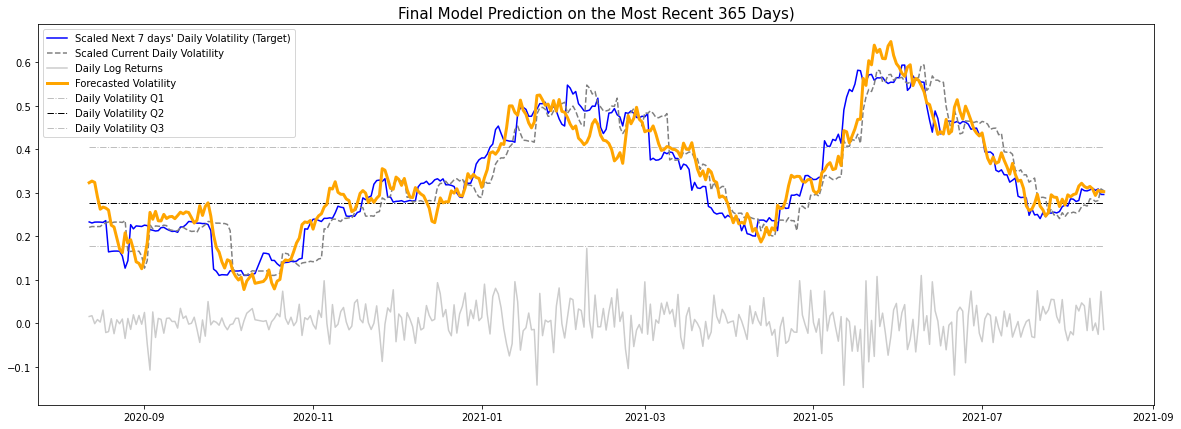

In [617]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
# ZOOMING IN THE LAST n_display VALUES
n_display = 365

plt.figure(figsize=(20,7))
plt.plot(vol_future_scaled[-n_display:], color='blue', 
            label=f"Scaled Next {n_future} days' Daily Volatility (Target)")
plt.plot(vol_current_scaled[-n_display:], color='gray',  ls='--',
            label=f"Scaled Current Daily Volatility")
plt.plot(df.log_returns[-n_display:], color='gray', alpha=0.4,
            label='Daily Log Returns')
plt.plot(y_preds_scaled[-n_display:], color='orange', lw=3,
            label=f'Forecasted Volatility')

plt.hlines(y=q1, color='gray', alpha=0.5, label='Daily Volatility Q1', ls='-.', lw=1,
           xmin=vol_future_scaled[-n_display:].index[0],
           xmax=vol_future_scaled[-n_display:].index[-1])

plt.hlines(y=q2, color='black', label='Daily Volatility Q2', ls='-.', lw=1,
           xmin=vol_future_scaled[-n_display:].index[0],
           xmax=vol_future_scaled[-n_display:].index[-1])

plt.hlines(y=q3, color='gray', alpha=0.5, label='Daily Volatility Q3', ls='-.', lw=1,
           xmin=vol_future_scaled[-n_display:].index[0],
           xmax=vol_future_scaled[-n_display:].index[-1])


plt.title(f'Final Model Prediction on the Most Recent {n_display} Days', fontsize=15)
plt.legend(loc='upper left')
plt.show();

In [615]:
RMSPE(df.vol_future[y_preds.index], y_preds)

0.19604452088463792

Well, I think I know why some of the outputs in the LSTM might look a bit off and totally out of the range we're aiming for - it's definitely partly because of my activation function!

Ref: https://bignerdranch.com/blog/implementing-swish-activation-function-in-keras/

Also, I might try different scalers for the multivariate LSTM.

Overfitting could be a result of too many variables in my models. 

Another feature that I can potentially include in my multivariate version is the US economic calendar. 

(Source: Positional Option Trading - Sinclair)
"Forget about whether volatility follows a GARCH(1,1) or a T-GARCH(1,2) process; the important observation is that **it clusters in the short term and mean reverts in the long term**."

"It is difficult to make money in financial markets. The EMH isn't
completely true, but it is closer to being correct than to being
wrong. If a trader can't accept this, she will see edges in noise and
consequently overtrade...

A promising trading strategy is one whose basis is independent
of the specific methods used to measure it. Start with
observation, then move to quantification and justification...

...to get positive expectation we need to make a forecast
that is both correct and more correct that the consensus."


(Source: https://www.nasdaq.com/articles/the-best-way-to-understand-bitcoin-volatility-2021-05-19)

Volatility is best defined as the 30-day standard deviation of daily log returns annualized. With this in mind, high volatility is at 100% or above, medium volatility is between 50% and 100%, while low volatility is below 50%. Right now, Bitcoin is at under $40k and approaching its February lows. 